In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import sys
sys.path.insert(0, 'utils/')
from factorizer import *
import ssd
import palettable
from scipy.interpolate import griddata
from palettable.cartocolors.qualitative import Prism_8
import matplotlib as mpl
import pickle
from mpl_toolkits.mplot3d import Axes3D
from IPython.utils import io
import os

import scipy.cluster.hierarchy as hac
from scipy.cluster.hierarchy import dendrogram, linkage

def cosine_abs(x,y):
    return 1.0 + 1e-5 - np.abs(np.dot(x,y))/np.sqrt(np.dot(x,x)*np.dot(y,y) + 1e-10)

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
fig_path = "./figures/kinsler/"
#create directory if it does not exist
try:
    os.mkdir(fig_path)
except:
    print(f"already have directory {fig_path}")

already have directory ./figures/kinsler/


In [3]:
od = pd.read_csv("data/elife-61271-fig2-data1-v2.csv", sep = ',') 

fitness_keys = od.keys()[7::2]
error_keys = od.keys()[8::2]

env_names = list(fitness_keys)
env_names = [e[:-8] for e in env_names]

E = len(env_names)

print("number of mutations", len(od['type']))

#filter unsequenced mutations
ECmean_thr = 0.05
error_thr = 0.5
filtered = []
for l,t in enumerate(od['type']):
    F_ECs = np.zeros(8)
    for e in range(8):
        F_ECs[e] = od[fitness_keys[e]][l]
    #print("%.3f  %.3f" %(np.mean(F_ECs)))
    
    F_errors = np.zeros(E)
    for e in range(E):
        F_errors[e] = od[error_keys[e]][l]
    #print("%.3f   %.3f" %(np.mean(F_errors), np.max(F_errors)))
    
    if t == "NotSequenced" or abs(np.mean(F_ECs)) < ECmean_thr or np.max(F_errors) > error_thr:
        filtered += [False]
    else:
        filtered += [True]
        
L = np.sum(filtered)

sorted_ = np.array(np.argsort(od['mutation_type'][filtered]),dtype=int)

print(E,L,env_names)

F = np.zeros((E,L))
Ferrs = np.zeros((E,L))

for e in range(len(fitness_keys)):
    F[e] = np.array(od[fitness_keys[e]][filtered])[sorted_]
    Ferrs[e] = np.array(od[error_keys[e]][filtered])[sorted_]
    
types_filt = [o for i,o in enumerate(list(od['mutation_type'])) if filtered[i]]
for i in range(len(types_filt)):
    if types_filt[i] == "IRA1_nonsense":
        types_filt[i] = "IRA1-non"
    if types_filt[i] == "IRA1_missense":
        types_filt[i] = "IRA1-mis"
loci_types = [types_filt[i] for i in sorted_]

#print(types_filt)

number of mutations 421
45 288 ['EC Batch 19', 'EC Batch 3', 'EC Batch 6', 'EC Batch 13', 'EC Batch 18', 'EC Batch 20', 'EC Batch 21', 'EC Batch 23', '12 hr Ferm', '8 hr Ferm', '22 hr Ferm', '18 hr Ferm', '1 Day', '3 Day', '4 Day', '5 Day', '6 Day', '7 Day', '0.5% DMSO', '8.5 μM GdA (B1)', 'Baffle, 1.4% Gluc', 'Baffle (B8)', 'Baffle, 1.6% Gluc', 'Baffle, 1.7% Gluc', 'Baffle, 1.8% Gluc', 'Baffle, 2.5% Gluc', 'Baffle, 0.4 μg/ml Ben', 'Baffle, 2 μg/ml Ben', 'EC 1BigBatch', 'Baffle (B9)', '1.4% Gluc', '1.8% Gluc', '0.2 M NaCl', '0.5 M NaCl', '0.2 M KCl', '0.5 M KCl', '8.5 μM GdA (B9)', '17 μM GdA', '2 μg/ml Flu', '0.5 μg/ml Flu', '1% Raf', '0.5% Raf', '1% Gly', '1% EtOH', '1.5% Suc, 1% Raf']


## Dataset 

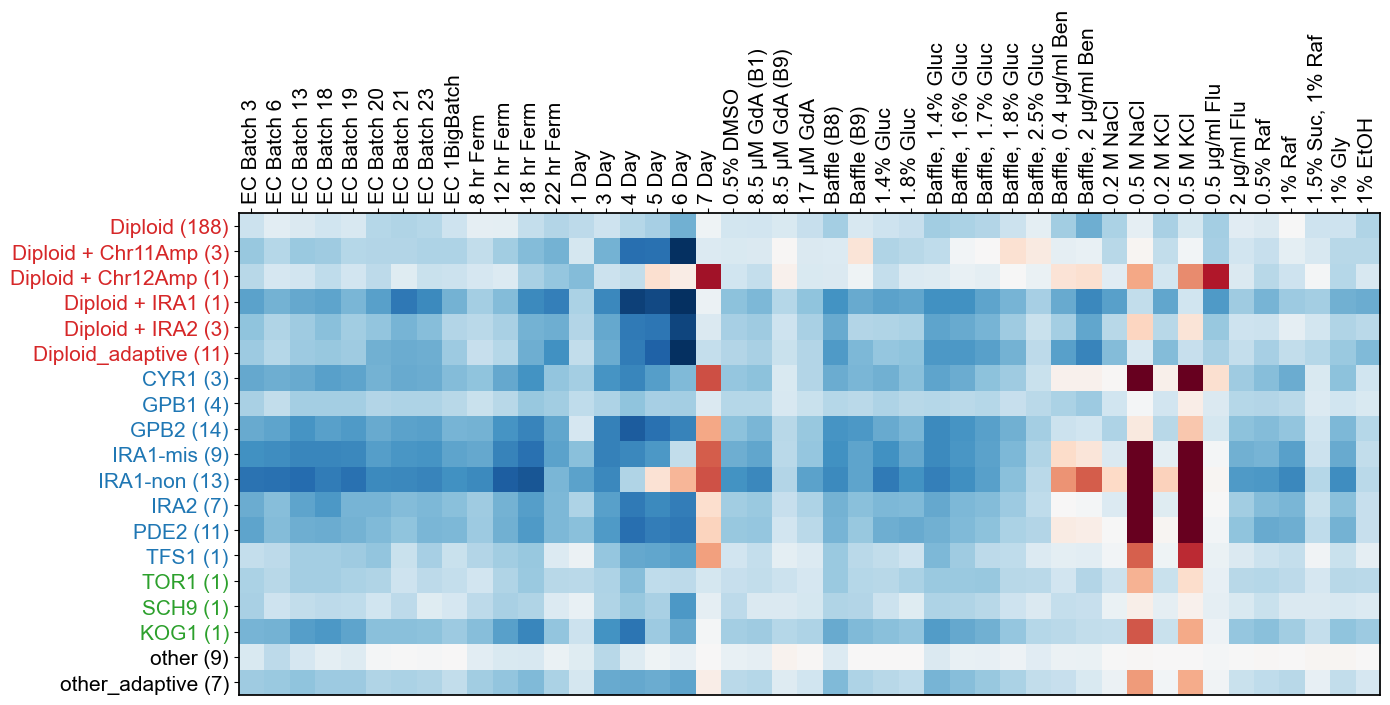

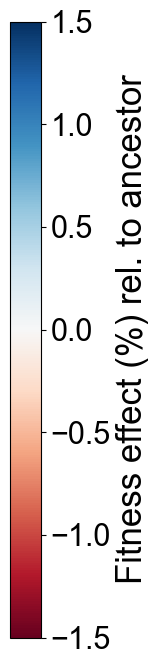

In [4]:
ecs_i = [i for i,e in enumerate(env_names) if e[:8] == "EC Batch"]

F_EC_avg = np.mean(F[ecs_i,:],axis=0)

argsorted_fromEC = np.arange(len(F))#np.argsort(np.mean((F - F_EC_avg)**2,axis=1))
sorted_fromEC = [env_names[i] for i in argsorted_fromEC]

loci_types_unique = []
for i in range(1,len(loci_types)):
    if loci_types[i-1] != loci_types[i]:
        loci_types_unique += [loci_types[i-1]]
loci_types_unique += [loci_types[-1]]

F_by_type = np.zeros((F.shape[0], len(loci_types_unique)))
num_by_type = np.zeros(len(loci_types_unique))
for it,t in enumerate(loci_types_unique):
    indices_by_type = [i for i,lt in enumerate(loci_types) if lt == t]
    #print(t, indices_by_type)
    F_by_type[:,it] = np.mean(F[:,indices_by_type],axis=1)# - 0*np.mean(F_EC_avg[indices_by_type])
    num_by_type[it] = len(indices_by_type)
    
    #print(F_by_type[:,it])
    
plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (14,8))

sort_by_pathway = [1,2,3,4,5,6,0,7,8,9,10,11,13,15,16,14,12,17,18]
loci_types_by_pathway = [loci_types_unique[i] for i in sort_by_pathway]

Fsorted = (F_by_type[:,sort_by_pathway])[argsorted_fromEC]

ordering = [1,2,3,4,0,5,6,7,28,9,8,11,10,12,13,14,15,16,17]
ordering += [18,19,36,37,21,29,30,31,20,22,23,24,25,26,27,32,33,34,35,39,38,41,40,44,42,43]
Fsorted = Fsorted[ordering]
envs_sorted = [sorted_fromEC[ordering[e]] for e in range(len(ordering))]

im = axis.imshow(Fsorted.T, vmin = -1.5, vmax = 1.5, cmap = "RdBu")

axis.tick_params(labelsize = 15)
axis.set_xticks(np.arange(F.shape[0]))
axis.set_xticklabels(envs_sorted, rotation =90)
axis.xaxis.set_ticks_position('top') 
axis.set_yticks(np.arange(F_by_type.shape[1]))


yticklabels = [loci_types_by_pathway[i] + " (%d)"%num_by_type[sort_by_pathway][i] \
               for i in range(len(loci_types_by_pathway))]

axis.set_yticklabels(yticklabels)
[yl.set_color("C3") for i,yl in enumerate(axis.get_yticklabels()) if i < 6]
[yl.set_color("C0") for i,yl in enumerate(axis.get_yticklabels()) if i >= 6 and i < 14]
[yl.set_color("C2") for i,yl in enumerate(axis.get_yticklabels()) if i >= 14 and i < 17]


for sp in ['top','bottom','left','right']:
    axis.spines[sp].set_linewidth(1.25)
    
#fig.tight_layout()
fig.tight_layout()
fig.savefig(fig_path + "kinsler_envs.pdf")
plt.show()

plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (14,8))

cb = fig.colorbar(mappable=im)
cb.ax.tick_params(labelsize = 22)
cb.set_label("Fitness effect (%) rel. to ancestor", fontsize = 25)

axis.remove()
fig.savefig(fig_path + "kinsler_envs_cb.pdf")

plt.show()

## Solution space 

('reg', 4, (0.0046, 0.4433), (0, 0)) 1.6890459363957597 1.9523809523809523 4 0.08534022451500957


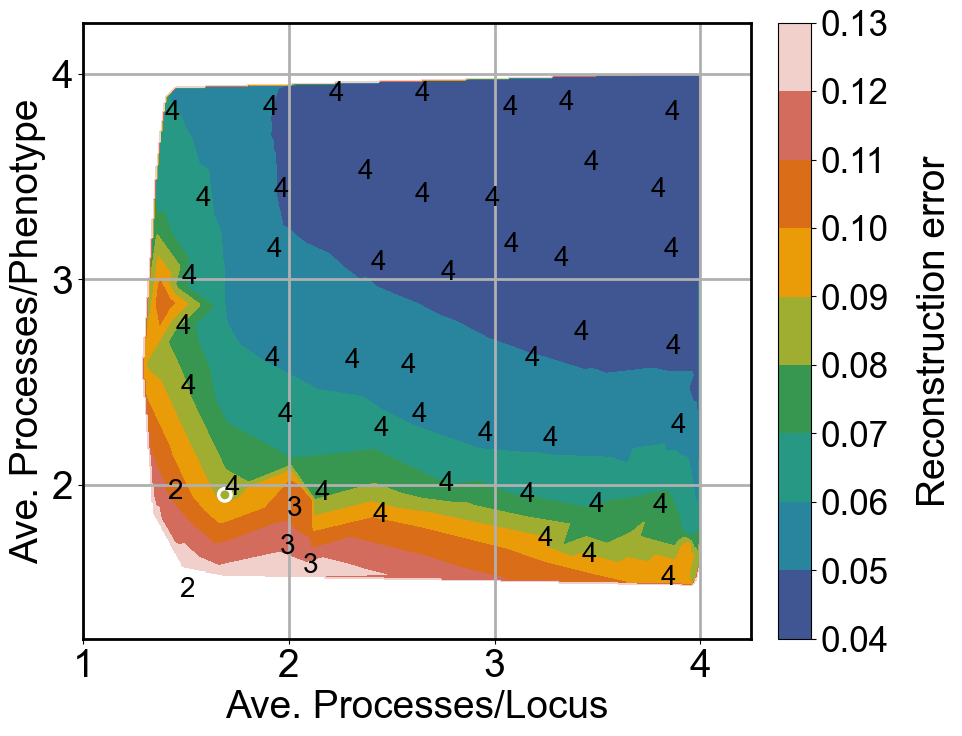

In [5]:
mode = "kinsler"
fcts= pickle.load(open(f"pickled_factorizers/{mode}","rb"))

lamb1_range = 10**(np.linspace(np.log10(1e-4),np.log10(1e-2),25))
lamb2_range = 10**(np.linspace(np.log10(1e-3),np.log10(1.5),25))
lamb1_fixed = [1e-4]
lamb2_fixed = [1e-3]

ve = .25
minx = 1.25-ve
maxx = 4+ve
miny = 1.5-ve
maxy = 4+ve
vmax = 0.13
vmin = 0.04

K = 4

name = mode
fct = fcts[(name , None,None)]

kpts = []
for i in np.linspace(1.5,3.8,7):
    for j in np.linspace(1.5,3.8,7):
        kpts.append((i,j))
        
cps = [(1.8,2)]
kpts += cps

plot_solution_space(fct, K, lamb1_range, lamb2_range,  minx, maxx, miny, maxy, vmax, vmin, \
                    fs = 28,scatter=False, scatter_restricted=True, restrict_in_range = True,\
                    k_labeled_points = kpts, circled_points = cps,  save_name = fig_path + "sols_" + mode + ".pdf")

#plot_solution_space(fct, K, lamb1_range,lamb2_range, minx, maxx, miny, maxy, vmax, vmin,fs = 23,\
                    #scatter=False, scatter_restricted=True, restrict_in_range = True, k_labeled_points = kpts , circled_points = labeled_points, save_name = fig_path + "sols_" + mode + ".pdf")

## Rotation tests 

4 45 288


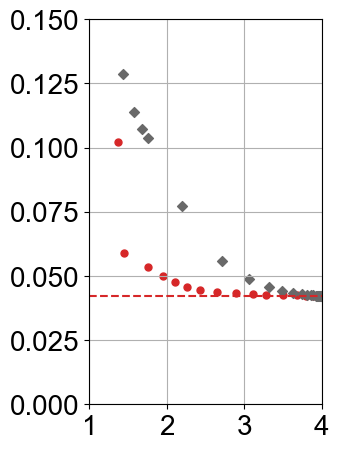

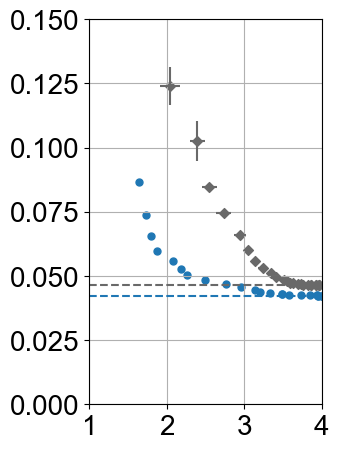

In [6]:
mode = "kinsler"
fcts= pickle.load(open(f"pickled_factorizers/{mode}","rb"))

lamb1_range = 10**(np.linspace(np.log10(1e-4),np.log10(1e-2),25))
lamb2_range = 10**(np.linspace(np.log10(1e-3),np.log10(1.5),25))
lamb1_fixed = [1e-4]
lamb2_fixed = [1e-3]
svd_k = 4
mws = 0

yrange = (0,.15)
xrange = (1,4)
figsize = (3,5)

name = mode
fct = fcts[(name , None,None)]
K = fct.computed_params(printout = False)[0][1]
print(K, fct.FF.shape[0], fct.FF.shape[1])

fct_rots = [fcts[(name, None, i)] for i in [3,4,5]] 
rotate = "loci"
plot_rotation_test_w_error(fct, fct_rots, K, lamb1_fixed, lamb2_range, xrange, yrange, rotate, fs = 20, svd_k=K, true_line = False, save_name = f"{fig_path}/{rotate}_rot_test.pdf", figsize = figsize, xticks = [1,2,3,4], oc='tab:red', rotc='dimgrey', labels= False, legend = False)

fct_rots = [fcts[(name, i, None)] for i in [0,1,2]] 
rotate = "env"
plot_rotation_test_w_error(fct, fct_rots, K, lamb1_range, lamb2_fixed, xrange, yrange, rotate, fs = 20, svd_k=K, true_line = False, save_name = f"{fig_path}/{rotate}_rot_test.pdf", figsize = figsize, xticks = [1,2,3,4], oc='tab:blue', rotc='dimgrey', labels= False, legend = False)

## Group by absolute cosine metric 

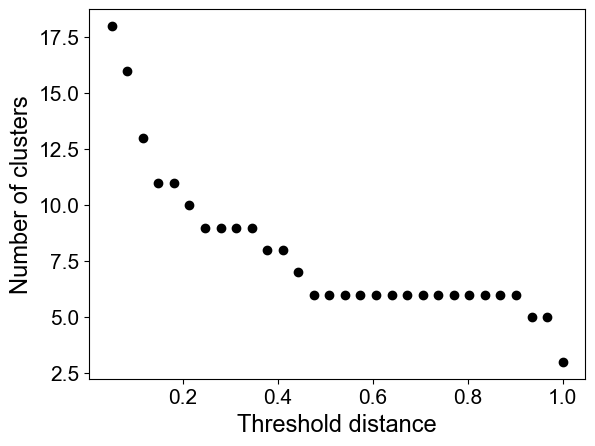

In [7]:
p = fct.find_key(1.8,2)
M = fct.M_preds[p]

filt = np.sum(M**2,axis=0) > 1e-4

Z = linkage(M.T[filt], metric = cosine_abs, method = 'complete', optimal_ordering=True)

cluster_labels = np.zeros(M.shape[1])
cluster_labels[filt] = hac.fcluster(Z,0.4, criterion='distance')

plt.close("all")
for thr in np.linspace(0.05,1,30):
    labs = hac.fcluster(Z,thr, criterion='distance')
    plt.plot([thr],[np.max(labs)+1],'ko')
    #print("%.2f  %d  %d" %(thr,np.max(labs)+1, np.min(labs)))
plt.tick_params(labelsize= 15)
plt.ylabel("Number of clusters", fontsize = 17)
plt.xlabel("Threshold distance", fontsize = 17)
plt.show()

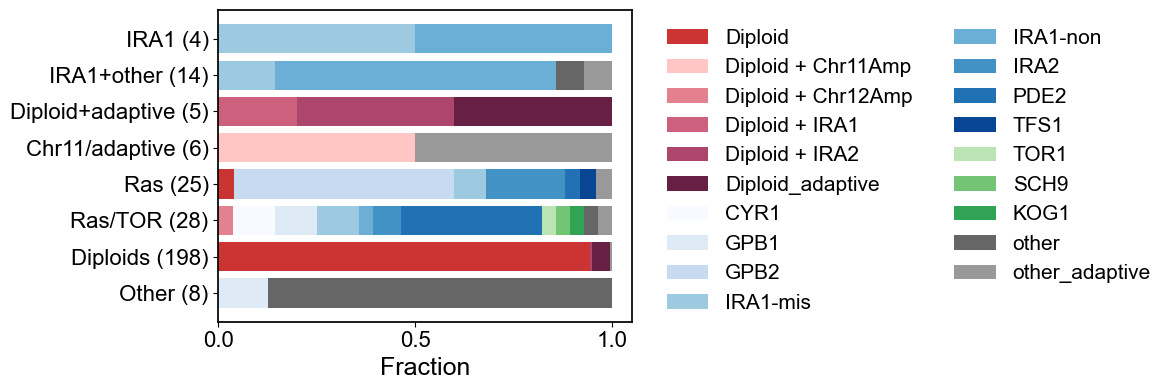

In [8]:
from palettable.colorbrewer.sequential import Blues_8
from palettable.colorbrewer.sequential import Greens_5
from palettable.cartocolors.qualitative import Antique_10
from palettable.cartocolors.sequential import Burg_5
from palettable.cartocolors.sequential import BluYl_6
from palettable.cartocolors.sequential import Emrld_6




cmap_colors = [(0.8,0.2,0.2)] + Burg_5.mpl_colors + Blues_8.mpl_colors + Greens_5.mpl_colors[1:4] + \
[(0.4,0.4,0.4)] + [(0.6,0.6,0.6)]

ncolors = len(cmap_colors)

num_clusters = int(np.max(cluster_labels))+1
type_distribution_by_cluster = np.zeros((num_clusters,len(loci_types_by_pathway)))
count = 0
for i in range(num_clusters):
    filt = cluster_labels == i 
    lnames = [l for j,l in enumerate(np.sort(types_filt)) if filt[j]]
    count += sum(filt)
    #print(sum(filt), lnames, count)
    for iu,u in enumerate(loci_types_by_pathway):
        counter = [1 for l in lnames if l == u]
        type_distribution_by_cluster[i,iu] = np.sum(counter)

#print(type_distribution_by_cluster)

type_frac_by_cluster = type_distribution_by_cluster/np.sum(type_distribution_by_cluster,axis=1)[:,None]

plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (12,4))

for iu,u in enumerate(loci_types_by_pathway):
    if iu == 0:
        axis.barh(np.arange(num_clusters)+1,type_frac_by_cluster[:,0], color = cmap_colors[iu%ncolors], label = u)
    else:
        axis.barh(np.arange(num_clusters)+1,type_frac_by_cluster[:,iu], \
                 left = np.sum(type_frac_by_cluster[:,:iu],axis=1), color = cmap_colors[iu%ncolors], label = u)

        #
        
axis.set_xlim(0,1.05)
#axis.set_ylim(0,1.05)
axis.tick_params(labelsize = 16)
axis.legend(fontsize = 15, bbox_to_anchor=(1.04,1), loc="upper left", frameon= False, ncol =2)
#axis.set_ylabel("Groups", fontsize = 22)
axis.set_xlabel("Fraction", fontsize = 18)
axis.set_yticks(np.arange(type_frac_by_cluster.shape[0])+1)
axis.set_xticks([0,0.5,1])
yticklabels = ["Other", "Diploids","Ras/TOR","Ras","Chr11/adaptive","Diploid+adaptive","IRA1+other","IRA1"]
num_per_group = np.sum(type_distribution_by_cluster,axis=1,dtype=int)
yticklabels = [x + " (%d)"%num_per_group[i] for i,x in enumerate(yticklabels)]
axis.set_yticklabels(yticklabels)
#axis.xaxis.set_label_position('top') 
#axis.xaxis.tick_top()

for sp in ['top','bottom','left','right']:
    axis.spines[sp].set_linewidth(1.25)


fig.tight_layout()
fig.savefig(fig_path + "kinsler_loci_clusters.pdf")
plt.show()

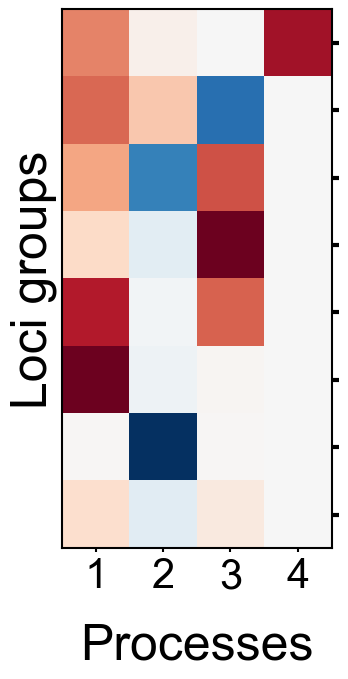

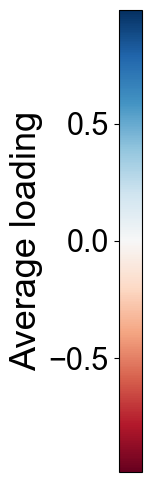

In [9]:
l_names = fct.loci_names 
params = fct.find_key(1.8,2)
M = fct.M_preds[params]

save_name = fig_path + "M_" + mode + ".pdf"

# if restricted is not None and sort == "names":
#     M = M[:,restricted]
#     l_names = [l for i,l in enumerate(l_names) if restricted[i]]

M, _ = cut_zero_mods(fct.M_preds[params],fct.W_preds[params])

Mnorm = M/np.sqrt(np.sum(M**2 + 1e-5,axis=0))

Mnew = np.zeros((M.shape[0],int(np.max(cluster_labels)+1)))
for i in range(Mnew.shape[1]):
    Mnew[:,i] = np.mean(Mnorm[:,cluster_labels == i],axis=1)

sorted_ = np.ones(Mnew.shape[1],dtype = bool)
M = deepcopy(Mnew)
l_names = np.arange(Mnew.shape[1]) + 1

xlabel = "Groups"

numl = M.shape[1]
pp = 99
labelsize = 30
colorlabels = ["k" for i in range(M.shape[1])]

plt.close("all")
fig, axis = plt.subplots(1, 1, figsize=(24, 7))
mm = np.percentile(np.abs(M), pp)
# print(mm, np.max(np.abs(M)))
im = axis.imshow(M[:, ::-1].T, cmap="RdBu", vmin=-mm, vmax=mm)
axis.tick_params(labelsize=labelsize, length= 3, width = 1.5)
axis.set_yticks(np.arange(numl))
axis.set_yticklabels([])
axis.yaxis.tick_right()

axis.set_xticks(np.arange(M.shape[0]))
axis.set_xticklabels(np.arange(M.shape[0])+1)
axis.yaxis.set_tick_params(length = 5, width = 3)
axis.set_ylabel("Loci groups",fontsize = labelsize*1.2)
#axis.set_xticklabels(np.arange(M.shape[0]))
[t.set_color(colorlabels[i]) for i, t in enumerate(axis.xaxis.get_ticklabels())]
axis.set_xlabel("Processes",fontsize = labelsize*1.2, labelpad = 20)

for sp in ["top", "bottom", "left", "right"]:
    axis.spines[sp].set_linewidth(1.5)
    
fig.savefig(save_name, bbox_inches='tight')
plt.show()

plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (8,6))
ax = fig.add_subplot(111)
cb = fig.colorbar(mappable=im,ax=[ax],location='left')
cb.ax.tick_params(labelsize = 22)
cb.set_label("Average loading", fontsize = 26)
ax.remove()
axis.remove()
fig.savefig(fig_path + "M_kinsler_cb.pdf")

plt.show()




## W matrix 

W: plot



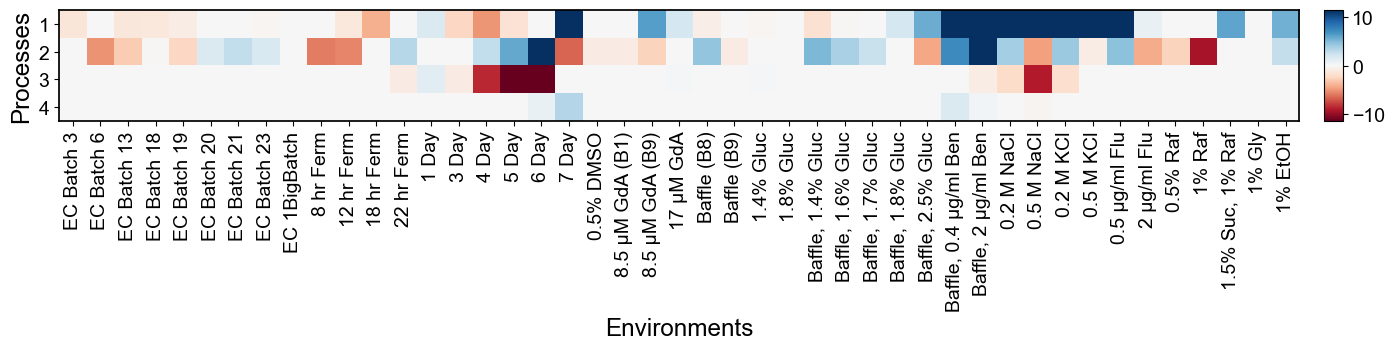

105
Module 	 Number of loci included
0	 165
1	 242
2	 66
3	 5


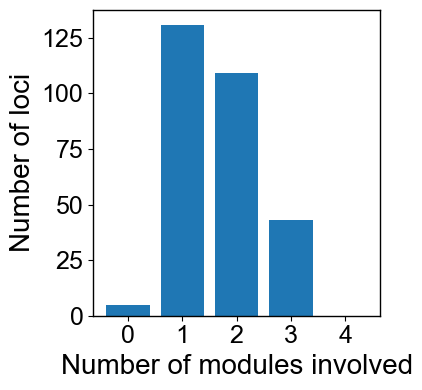

In [10]:
p = fct.find_key(1.8,2)
aspect = [1.02,0.0,0.015,1]
ordering = [1,2,3,4,0,5,6,7,28,9,8,11,10,12,13,14,15,16,17]
ordering += [18,19,36,37,21,29,30,31,20,22,23,24,25,26,27,32,33,34,35,39,38,41,40,44,42,43]
plot_Ws(fct, p, pp = 95, labelsize = 14,save_name = fig_path + "W_" + mode + ".pdf", colorbar_aspect = aspect,ordering=ordering)
F = fct.FF
filtl =  np.mean(np.abs(F),axis=0) > 0.9
print(np.sum(filtl))
#plot_Ms(fct, p, pp = 97, restricted = filtl, two_line= False, labelsize = 24, max_cols = 120, save_name = fig_path + "M_" + mode + ".pdf")
display_modularity(fct, p, save_name =  fig_path + "modhist_" + mode + ".pdf")

## Compare SSD and SVD solutions for Kinsler et al data 

W: plot



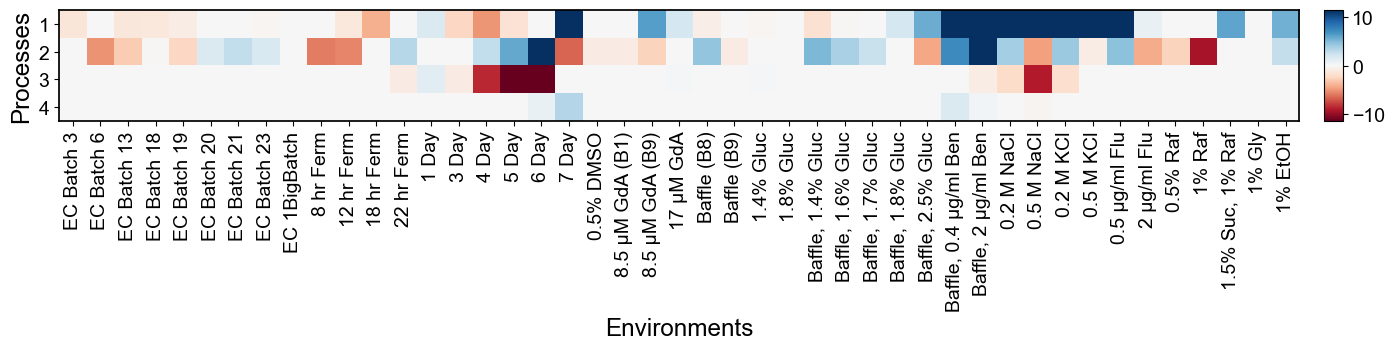

W: plot



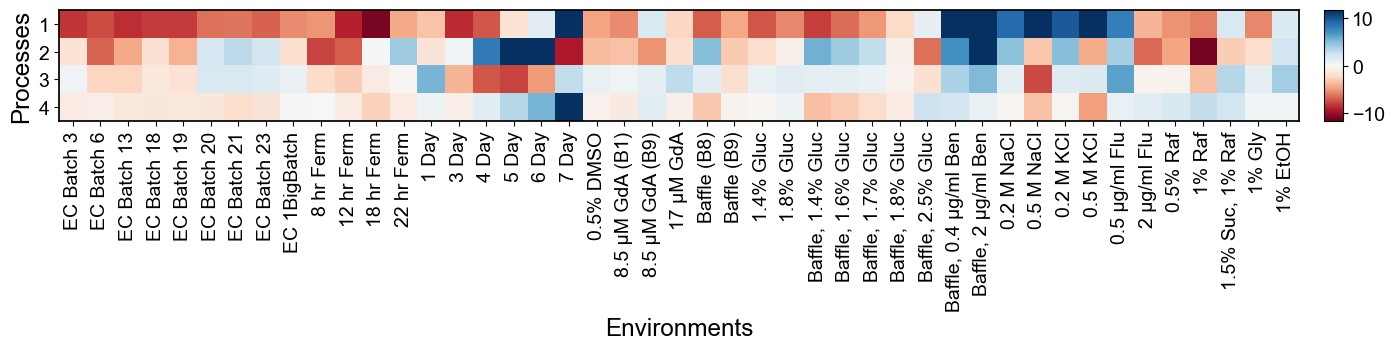

In [11]:
mode = "kinsler"
fcts= pickle.load(open(f"pickled_factorizers/{mode}","rb"))

K = 4

name = mode
fct = fcts[(name , None,None)]
p = fct.find_key(1.8,2)
p_svd = ('svd', 4, None, (0, 0))

aspect = [1.02,0.0,0.015,1]
ordering = [1,2,3,4,0,5,6,7,28,9,8,11,10,12,13,14,15,16,17]
ordering += [18,19,36,37,21,29,30,31,20,22,23,24,25,26,27,32,33,34,35,39,38,41,40,44,42,43]
plot_Ws(fct, p, pp = 95, labelsize = 14,save_name = None, colorbar_aspect = aspect,ordering=ordering)


plot_Ws(fct, p_svd, pp = 95.5, labelsize = 14,save_name = "./figures/kinsler/" + "W_" + "svd" + ".pdf", colorbar_aspect = aspect,ordering=ordering)



## Cluster M from SVD 

In [12]:
F = fct.FTrue
M, W = ssd.run_svd(F - np.mean(F, axis=0), 4, 1e-3, 1e-3)

filt = np.sum(M**2,axis=0) > 1e-4

Z = linkage(M.T[filt], metric = cosine_abs, method = 'complete', optimal_ordering=True)

cluster_labels = np.zeros(M.shape[1])
cluster_labels[filt] = hac.fcluster(Z,0.48, criterion='distance')

print(np.max(cluster_labels)+1, np.min(cluster_labels), np.sum(filt))
print(int(np.max(cluster_labels))+1 - int(np.min(cluster_labels)))

10.0 1.0 288
9


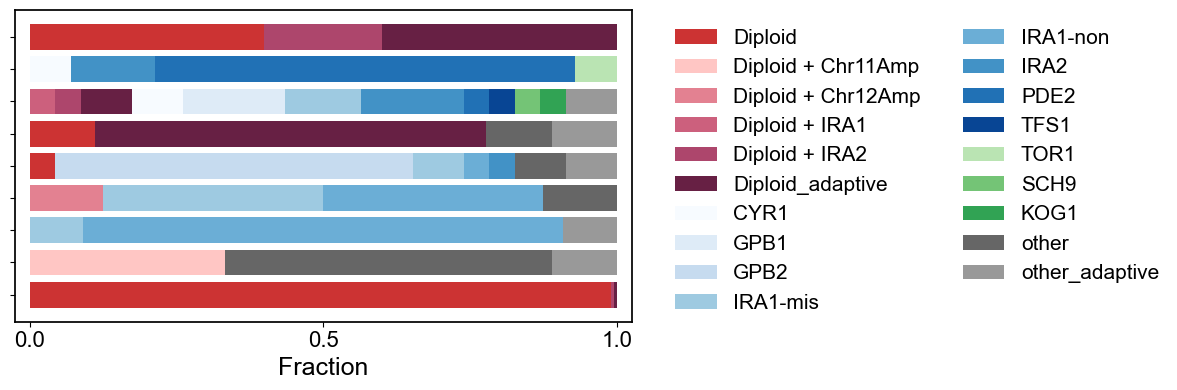

In [13]:
from palettable.colorbrewer.sequential import Blues_8
from palettable.colorbrewer.sequential import Greens_5
from palettable.cartocolors.qualitative import Antique_10
from palettable.cartocolors.sequential import Burg_5
from palettable.cartocolors.sequential import BluYl_6
from palettable.cartocolors.sequential import Emrld_6


cmap_colors = [(0.8,0.2,0.2)] + Burg_5.mpl_colors + Blues_8.mpl_colors + Greens_5.mpl_colors[1:4] + \
[(0.4,0.4,0.4)] + [(0.6,0.6,0.6)]

ncolors = len(cmap_colors)

num_clusters = int(np.max(cluster_labels)) +1 - int(np.min(cluster_labels))
type_distribution_by_cluster = np.zeros((num_clusters,len(loci_types_by_pathway)))
count = 0
for i in range(num_clusters):
    filt = cluster_labels == i + int(np.min(cluster_labels))
    lnames = [l for j,l in enumerate(np.sort(types_filt)) if filt[j]]
    count += sum(filt)
    #print(sum(filt), lnames, count)
    for iu,u in enumerate(loci_types_by_pathway):
        counter = [1 for l in lnames if l == u]
        type_distribution_by_cluster[i,iu] = np.sum(counter)

#print(type_distribution_by_cluster)

type_frac_by_cluster = type_distribution_by_cluster/np.sum(type_distribution_by_cluster,axis=1)[:,None]

plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (12,4))

for iu,u in enumerate(loci_types_by_pathway):
    if iu == 0:
        axis.barh(np.arange(num_clusters)+1,type_frac_by_cluster[:,0], color = cmap_colors[iu%ncolors], label = u)
    else:
        axis.barh(np.arange(num_clusters)+1,type_frac_by_cluster[:,iu], \
                 left = np.sum(type_frac_by_cluster[:,:iu],axis=1), color = cmap_colors[iu%ncolors], label = u)

        #
        
axis.set_xlim(-0.025,1.025)
#axis.set_ylim(0,1.05)
axis.tick_params(labelsize = 16)
axis.legend(fontsize = 15, bbox_to_anchor=(1.04,1), loc="upper left", frameon= False, ncol =2)
#axis.set_ylabel("Groups", fontsize = 22)
axis.set_xlabel("Fraction", fontsize = 18)
axis.set_yticks(np.arange(type_frac_by_cluster.shape[0])+1)
axis.set_xticks([0,0.5,1])
#yticklabels = ["Other", "Diploids","Ras/TOR","Ras","Chr11/adaptive","Diploid+adaptive","IRA1+other","IRA1"]
#num_per_group = np.sum(type_distribution_by_cluster,axis=1,dtype=int)
#yticklabels = [x + " (%d)"%num_per_group[i] for i,x in enumerate(yticklabels)]
axis.set_yticklabels([])
#axis.xaxis.set_label_position('top') 
#axis.xaxis.tick_top()

for sp in ['top','bottom','left','right']:
    axis.spines[sp].set_linewidth(1.25)

fig.tight_layout()
fig.savefig(fig_path + "kinsler_loci_clusters_svd.pdf")
plt.show()

[[-0.0179465  -0.05618194 -0.72509943 -0.56858049 -0.31175847 -0.04808881
  -0.4784657  -0.67012341 -0.08932234]
 [ 0.79413291  0.36277986 -0.37757149 -0.09381412  0.20095617  0.88050531
   0.4589784   0.21218178  0.75953844]
 [ 0.5068197  -0.60047516  0.49717268 -0.19205072 -0.71651806 -0.39442049
  -0.64539339 -0.04933993 -0.09988087]
 [-0.23188406  0.35729876 -0.24838684 -0.70728477 -0.55120482 -0.06036858
   0.03357698  0.68031718  0.56834961]]


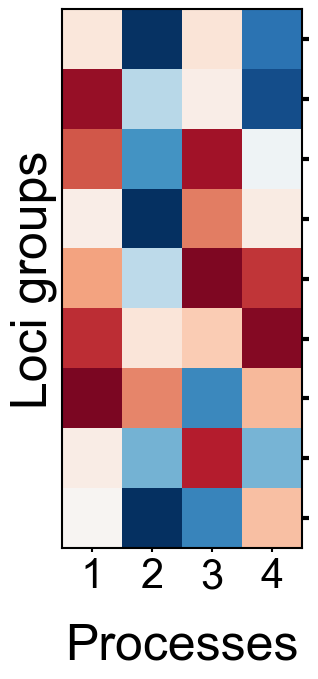

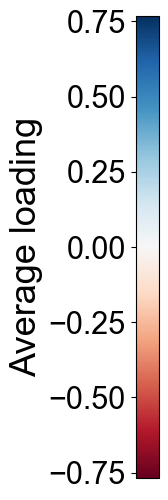

In [14]:
l_names = fct.loci_names 
save_name = fig_path + "M_" + mode + "_svd.pdf"

M, W = ssd.run_svd(F - np.mean(F, axis=0), 4, 1e-3, 1e-3)

M, _ = cut_zero_mods(M,W)


Mnorm = M/np.sqrt(np.sum(M**2 + 1e-5,axis=0))


Mnew = np.zeros((M.shape[0],int(np.max(cluster_labels)+1 - np.min(cluster_labels))))
for i in range(Mnew.shape[1]):
    Mnew[:,i] = np.nanmean(Mnorm[:,cluster_labels == i + int(np.min(cluster_labels))],axis=1)
    

sorted_ = np.ones(Mnew.shape[1],dtype = bool)
M = deepcopy(Mnew)
l_names = np.arange(Mnew.shape[1]) + 1


print(M)

xlabel = "Groups"

numl = M.shape[1]
pp = 95
labelsize = 30
colorlabels = ["k" for i in range(M.shape[1])]

plt.close("all")
fig, axis = plt.subplots(1, 1, figsize=(24, 7))
mm = np.percentile(np.abs(M), pp)
# print(mm, np.max(np.abs(M)))
im = axis.imshow(M[:, ::-1].T, cmap="RdBu", vmin=-mm, vmax=mm)
axis.tick_params(labelsize=labelsize, length= 3, width = 1.5)
axis.set_yticks(np.arange(numl))
axis.set_yticklabels([])
axis.yaxis.tick_right()

axis.set_xticks(np.arange(M.shape[0]))
axis.set_xticklabels(np.arange(M.shape[0])+1)
axis.yaxis.set_tick_params(length = 5, width = 3)
axis.set_ylabel("Loci groups",fontsize = labelsize*1.2)
#axis.set_xticklabels(np.arange(M.shape[0]))
[t.set_color(colorlabels[i]) for i, t in enumerate(axis.xaxis.get_ticklabels())]
axis.set_xlabel("Processes",fontsize = labelsize*1.2, labelpad = 20)

for sp in ["top", "bottom", "left", "right"]:
    axis.spines[sp].set_linewidth(1.5)
    
fig.savefig(save_name, bbox_inches='tight')
plt.show()

plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (8,6))
ax = fig.add_subplot(111)
cb = fig.colorbar(mappable=im,ax=[ax],location='left')
cb.ax.tick_params(labelsize = 22)
cb.set_label("Average loading", fontsize = 26)
ax.remove()
axis.remove()
fig.savefig(fig_path + "M_kinsler_cb_svd.pdf")

plt.show()




## Bi-cross validation

In [15]:
def bicross_validation(F,K,lfilt,efilt, method = 'ssd',lamb1 = 1e-3,lamb2 = 1e-3):
    #split F 
    F_D = (F[:,lfilt])[efilt] #train loci, train envs
    F_A = (F[:,~lfilt])[~efilt] #test loci, test envs

    F_B = (F[:,~lfilt])[efilt] #test loci, train envs
    F_C = (F[:,lfilt])[~efilt] #train loci, test envs
    
    if method == 'ssd':
        Ws,Ms,bs, mods, ndls = ssd.run_factorizer_regularized_range(F_D, K, [lamb1], [lamb2],norm="loci",fit_intercept = False)
        W_D = Ws[0,0]
        M_D = Ms[0,0]
        F_D_pred = W_D@M_D

        M_B,b_B = ssd.optimize_M(F_B,W_D,l2, fit_intercept=False,norm="loci")
        W_C = ssd.optimize_W(F_C, M_D, l1, norm="loci")

        F_A_pred = W_C@M_B + b_B
        
        Keff = int(np.ceil(np.sum(M_D**2)))
        modl = ssd.ave_mod_per_loci(np.concatenate((M_D,M_B),axis=1))
        mode = ssd.ave_mod_per_env(np.concatenate((W_C,W_D),axis=0))
        
        #F_A_pred = (F_C@np.linalg.pinv(F_D_pred))@F_B 
    else:
        M_D,W_D = ssd.run_svd(F_D,K)
        
        F_D_pred = W_D@M_D
        
        #print(F_B.shape,np.linalg.pinv(F_D_pred).shape, F_C.shape )
        
        F_A_pred = (F_C@np.linalg.pinv(F_D_pred))@F_B
        
        Keff = K
        modl = K
        mode = K
        
    return F_A_pred, Keff, modl, mode

def svd_vs_ssd_bicross(F,K,lfilt,efilt,l1,l2,n_types):
    Fsub = F - np.mean(F,axis=0)
    with io.capture_output() as captured:
        F_A_pred_ssd,Keff_ssd, modl_ssd, mode_ssd = bicross_validation(Fsub,K,lfilt,efilt,lamb1 = l1,lamb2 = l2)
        F_A_pred_svd,Keff_svd, modl_svd, mode_svd = bicross_validation(Fsub,Keff_ssd,lfilt,efilt,method = 'svd')

    F_A = (Fsub[:,~lfilt])[~efilt]
    R2s_svd = np.zeros(F_A_pred_svd.shape[0])
    R2s_ssd = np.zeros(F_A_pred_svd.shape[0])
    
    R2_all_svd = 0
    R2_all_ssd = 0
    n_types = np.zeros(len(test_loci_ind))
    for i in range(len(test_loci_ind)):
        n_types[i] = num_in_test[loci_types_unique.index(loci_types[test_loci_ind[i]])]
        #print(n_type, test_loci_ind[i], loci_types[test_loci_ind[i]])

    for j in range(F_A_pred_svd.shape[0]):
        num = np.sum(((F_A[j] - F_A_pred_svd[j])**2)/n_types)
        den = np.sum(((F_A[j] - np.mean(F_A[j]))**2)/n_types)
        R2s_svd[j] = 1 - num/den

        num = np.sum(((F_A[j] - F_A_pred_ssd[j])**2)/n_types)
        den = np.sum(((F_A[j] - np.mean(F_A[j]))**2)/n_types)
        R2s_ssd[j] = 1 - num/den  
        
    num1 = 0
    den1 = 0
    num2 = 0
    den2 = 0
    
    for i in range(F_A_pred_svd.shape[0]):
        for j in range(F_A_pred_svd.shape[1]):
            num1 += ((F_A[i,j] - F_A_pred_svd[i,j])**2)/n_types[j]
            den1 += ((F_A[i,j] - np.mean(F_A))**2)/n_types[j]
            

            num2 += ((F_A[i,j] - F_A_pred_ssd[i,j])**2)/n_types[j]
            den2 += ((F_A[i,j] - np.mean(F_A))**2)/n_types[j]
            
    R2_all_svd = 1 - num1/den1
    R2_all_ssd = 1 - num2/den2
    
    return R2s_ssd, R2s_svd, R2_all_svd, R2_all_ssd, modl_ssd, mode_ssd, Keff_ssd

def plot_svd_vs_ssd_comparison(F,K,lfilt,efilt,l1,l2,n_types):
    R2s_ssd, R2s_svd, R2_all_svd, R2_all_ssd, modl_ssd, mode_ssd, Keff_ssd \
    = svd_vs_ssd_bicross(F,K,lfilt,efilt,l1,l2,n_types)

    test_loci_ind = np.arange(len(loci_types))[~lfilt]
    #num_in_test = len(lfilt) - np.sum(lfilt)
    env_in_test = [env_names[i] for i in range(len(env_names)) if ~efilt[i]]

    sorted_ = np.argsort(-R2s_svd)
    sorted_envs = [env_in_test[sorted_[i]] for i in range(len(sorted_))]
    plt.close("all")
    fig,axis = plt.subplots(1,1,figsize = (8,4))
    axis.plot(R2s_svd[sorted_],'o')
    axis.plot(R2s_ssd[sorted_],'o')
    axis.set_xticks(np.arange(len(env_in_test)))
    axis.set_xticklabels(sorted_envs, rotation = 90, fontsize = 14)
    axis.tick_params(labelsize = 15)
    axis.set_ylim(-0.15,1)
    plt.show()

    print("%.3f %.3f %.3f %d"%(np.mean(R2s_ssd - R2s_svd), modl_ssd,mode_ssd, Keff_ssd))
    
def get_train_and_test_mutants_kinsler(loci_types, loci_types_unique,num_in_train):
    choices = []
    for l,name in enumerate(loci_types_unique):
        indices_of_type = [i for i in range(len(loci_types)) if loci_types[i] == name]
        choice = list(np.random.choice(indices_of_type, size = num_in_train[l],replace = False))
        choices += choice
        #print(name,choice)

    lfilt = np.zeros(len(loci_types), dtype = bool)
    lfilt[choices] = True  
    return lfilt

In [16]:
#number of loci of each type in the training set
num_per_type = np.array([sum([True for i in range(len(loci_types))\
                              if loci_types[i] == name]) for name in loci_types_unique])
num_in_train = np.array([1,20,1,0,0,1,5,2,7,4,6,4,0,5,0,0,0,4,0]) #from kinsler et al (with minor modifications to IRA1-non and other)
num_in_test = num_per_type - num_in_train
#get training and test loci
lfilt = get_train_and_test_mutants_kinsler(loci_types, loci_types_unique,num_in_train)

test_loci_ind = np.arange(len(loci_types))[~lfilt]
n_types = np.zeros(len(test_loci_ind))
for i in range(len(test_loci_ind)):
    n_types[i] = num_in_test[loci_types_unique.index(loci_types[test_loci_ind[i]])]
    
mode = "kinsler"
fcts= pickle.load(open(f"pickled_factorizers/{mode}","rb"))

name = mode
fct = fcts[(name , None,None)]

F = fct.FF

## Split into training and test sets a la Kinsler et al 

In [17]:
#split subtle and strong perturbation environments
strong = np.sort([10,12,13,14,15,16,17,37,24,25,43,19,44,32,33,34,35,39,26,27]) #from kinsler et al
efilt = np.ones(len(env_names), dtype = bool)
efilt[strong] = False

In [18]:
K = 10
ntrials = 1


lamb2_range = 10**(np.linspace(np.log10(1e-3),np.log10(0.5),20))
lamb1_range = 10**(np.linspace(np.log10(1e-3),np.log10(0.01),10))

R2s_diffs = np.zeros((len(lamb1_range),len(lamb2_range),ntrials))
R2_all_svds = np.zeros((len(lamb1_range),len(lamb2_range),ntrials))
R2_all_ssds = np.zeros((len(lamb1_range),len(lamb2_range),ntrials))
modls =  np.zeros((len(lamb1_range),len(lamb2_range),ntrials))
modes =  np.zeros((len(lamb1_range),len(lamb2_range),ntrials))
Ks =  np.zeros((len(lamb1_range),len(lamb2_range),ntrials))

for nt in range(ntrials):
    np.random.seed(nt)
    #get training and test loci
    lfilt = get_train_and_test_mutants_kinsler(loci_types, loci_types_unique,num_in_train)

    test_loci_ind = np.arange(len(loci_types))[~lfilt]
    n_types = np.zeros(len(test_loci_ind))
    for i in range(len(test_loci_ind)):
        n_types[i] = num_in_test[loci_types_unique.index(loci_types[test_loci_ind[i]])]

    for il1,l1 in enumerate(lamb1_range):
        for il2,l2 in enumerate(lamb2_range):
            #l1 = 0.0005
            R2s_ssd, R2s_svd,R2_all_svd, R2_all_ssd, modl_ssd, mode_ssd, Keff_ssd = svd_vs_ssd_bicross(F,K,lfilt,efilt,l1,l2,n_types)
            R2s_diffs[il1,il2,nt] = -np.mean(R2s_ssd - R2s_svd)
            R2_all_svds[il1,il2,nt] = np.mean(R2s_svd)
            R2_all_ssds[il1,il2,nt] = np.mean(R2s_ssd)
            modls[il1,il2,nt]  = modl_ssd
            modes[il1,il2,nt]  = mode_ssd
            Ks[il1,il2,nt] = Keff_ssd
            print("%.4f %.4f %02d %.2f %.2f %.3f %.3f %.3f" \
                  %(l1,l2,Keff_ssd,modl_ssd, mode_ssd, np.mean(R2s_ssd - R2s_svd), np.mean(R2s_svd), np.mean(R2s_ssd)))


0.0010 0.0010 10 9.45 8.11 -0.047 0.590 0.543
0.0010 0.0014 10 9.20 8.02 -0.045 0.590 0.544
0.0010 0.0019 10 8.79 7.80 -0.050 0.590 0.540
0.0010 0.0027 10 8.22 8.00 -0.059 0.590 0.530
0.0010 0.0037 10 7.42 8.18 -0.062 0.590 0.527
0.0010 0.0051 10 6.43 8.13 -0.038 0.590 0.552
0.0010 0.0071 10 5.55 8.33 -0.024 0.590 0.565
0.0010 0.0099 09 4.51 7.56 -0.042 0.606 0.563
0.0010 0.0137 09 3.83 7.60 -0.102 0.606 0.504
0.0010 0.0190 08 3.33 6.89 -0.132 0.610 0.477
0.0010 0.0263 08 2.43 6.91 -0.108 0.610 0.502
0.0010 0.0365 07 2.12 6.11 -0.093 0.592 0.498
0.0010 0.0507 05 1.86 4.64 -0.015 0.438 0.423
0.0010 0.0703 04 1.75 3.67 -0.102 0.472 0.370
0.0010 0.0974 03 1.65 2.84 -0.098 0.463 0.365
0.0010 0.1351 03 1.51 2.87 -0.108 0.463 0.355
0.0010 0.1874 02 1.35 2.00 -0.118 0.467 0.349
0.0010 0.2599 02 1.21 1.98 -0.143 0.467 0.324
0.0010 0.3605 02 1.10 1.98 -0.157 0.467 0.311
0.0010 0.5000 01 1.00 1.00 -0.038 0.288 0.250
0.0013 0.0010 10 9.32 7.67 -0.047 0.590 0.542
0.0013 0.0014 10 9.08 7.73 -0.046 

0.0077 0.5000 01 1.00 1.00 -0.058 0.288 0.230
0.0100 0.0010 08 7.86 3.18 -0.192 0.610 0.418
0.0100 0.0014 08 7.80 3.13 -0.190 0.610 0.420
0.0100 0.0019 07 6.81 3.07 -0.162 0.592 0.430
0.0100 0.0027 07 6.77 3.00 -0.159 0.592 0.433
0.0100 0.0037 07 6.41 2.96 -0.155 0.592 0.437
0.0100 0.0051 07 5.87 2.80 -0.149 0.592 0.443
0.0100 0.0071 06 5.47 2.73 -0.114 0.572 0.458
0.0100 0.0099 04 3.75 2.11 -0.133 0.472 0.339
0.0100 0.0137 04 2.43 1.91 -0.145 0.472 0.327
0.0100 0.0190 03 1.98 1.64 -0.134 0.463 0.329
0.0100 0.0263 03 1.97 1.64 -0.133 0.463 0.330
0.0100 0.0365 02 1.94 1.62 -0.137 0.467 0.330
0.0100 0.0507 02 1.92 1.62 -0.138 0.467 0.330
0.0100 0.0703 02 1.91 1.71 -0.140 0.467 0.327
0.0100 0.0974 02 1.88 1.78 -0.148 0.467 0.320
0.0100 0.1351 02 1.64 1.80 -0.160 0.467 0.307
0.0100 0.1874 02 1.39 1.78 -0.177 0.467 0.290
0.0100 0.2599 02 1.27 1.78 -0.188 0.467 0.279
0.0100 0.3605 01 1.00 1.00 -0.056 0.288 0.233
0.0100 0.5000 01 1.00 1.00 -0.067 0.288 0.222


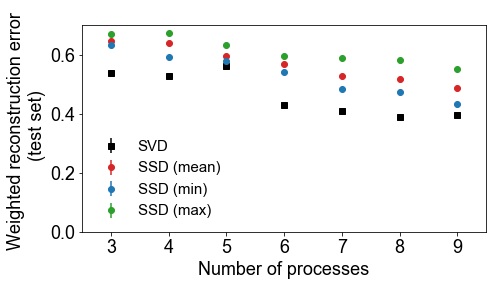

In [19]:
Ks_flat = np.reshape(Ks,(-1,ntrials))
R2_all_ssds_flat  = np.reshape(R2_all_ssds,(-1,ntrials))
R2_all_svds_flat  = np.reshape(R2_all_svds,(-1,ntrials))
modls_flat = np.reshape(modls,(-1,ntrials))
modes_flat = np.reshape(modes,(-1,ntrials))

Krange = np.arange(1,10)
R2_svd_k_nt = np.zeros((len(Krange),ntrials))
R2_ssd_k_nt_mean = np.zeros((len(Krange),ntrials))
R2_ssd_k_nt_max = np.zeros((len(Krange),ntrials))
R2_ssd_k_nt_min = np.zeros((len(Krange),ntrials))

for ik,k in enumerate(Krange):
    for nt in range(ntrials):
        filt_k = Ks_flat[:,nt] == k
        if np.sum(filt_k) > 1e-5:
            R2_svd_k_nt[ik,nt] = np.mean(R2_all_svds_flat[filt_k,nt])
            R2_ssd_k_nt_mean[ik,nt] = np.mean(R2_all_ssds_flat[filt_k,nt])
            R2_ssd_k_nt_max[ik,nt] = np.max(R2_all_ssds_flat[filt_k,nt])
            R2_ssd_k_nt_min[ik,nt] = np.min(R2_all_ssds_flat[filt_k,nt])
        
plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (7,4))
axis.tick_params(labelsize = 18)
axis.set_ylim(0.0,0.7)
axis.set_xlim(2.5,9.5)
axis.errorbar(Krange, 1-np.mean(R2_svd_k_nt,axis=1), yerr = np.std(R2_svd_k_nt,axis=1)/np.sqrt(ntrials), fmt='ks', label = "SVD")
axis.errorbar(Krange, 1-np.mean(R2_ssd_k_nt_mean,axis=1), yerr = np.std(R2_ssd_k_nt_mean,axis=1)/np.sqrt(ntrials), fmt='C3o', label = "SSD (mean)")
axis.errorbar(Krange, 1-np.mean(R2_ssd_k_nt_max,axis=1), yerr = np.std(R2_ssd_k_nt_max,axis=1)/np.sqrt(ntrials), fmt='C0o', label = "SSD (min)")
axis.errorbar(Krange, 1-np.mean(R2_ssd_k_nt_min,axis=1), yerr = np.std(R2_ssd_k_nt_min,axis=1)/np.sqrt(ntrials), fmt='C2o', label = "SSD (max)")


axis.set_ylabel("Weighted reconstruction error \n (test set)", fontsize = 18)
axis.set_xlabel("Number of processes", fontsize = 18)
axis.legend(frameon=False, fontsize = 15)
fig.tight_layout()
fig.savefig(fig_path +"bicross_svd_ssd_subtle_strong_envs.pdf")
plt.show()        

In [18]:
print(np.sum(efilt))

25


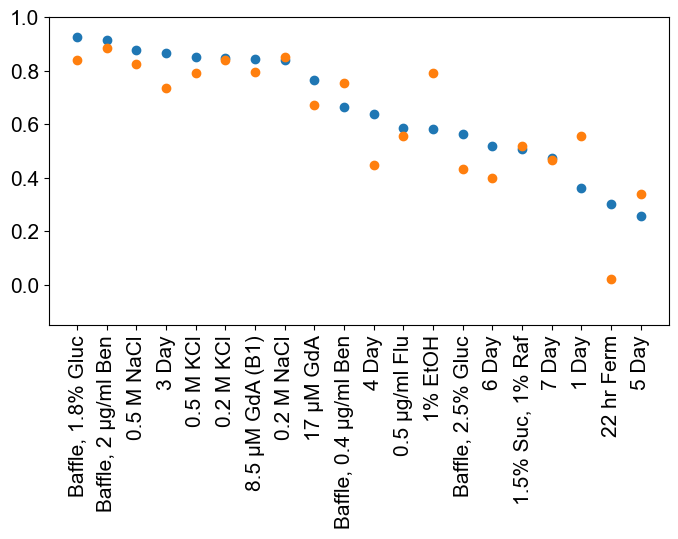

-0.034 7.972 7.844 8


In [19]:
l1 = 0.0001
l2 = 0.0001
#0.0036 0.0123
K = 8

plot_svd_vs_ssd_comparison(F,K,lfilt,efilt,l1,l2, n_types)

## Split into training and test environments randomly

In [22]:
K = 10
ntrials = 8

lamb2_range = 10**(np.linspace(np.log10(1e-3),np.log10(0.5),20))
lamb1_range = 10**(np.linspace(np.log10(1e-3),np.log10(0.01),10))

R2s_diffs = np.zeros((len(lamb1_range),len(lamb2_range),ntrials))
R2_all_svds = np.zeros((len(lamb1_range),len(lamb2_range),ntrials))
R2_all_ssds = np.zeros((len(lamb1_range),len(lamb2_range),ntrials))
modls =  np.zeros((len(lamb1_range),len(lamb2_range),ntrials))
modes =  np.zeros((len(lamb1_range),len(lamb2_range),ntrials))
Ks =  np.zeros((len(lamb1_range),len(lamb2_range),ntrials))

for nt in range(ntrials):
    np.random.seed(nt)
    #get training and test loci
    lfilt = get_train_and_test_mutants_kinsler(loci_types, loci_types_unique,num_in_train)

    test_loci_ind = np.arange(len(loci_types))[~lfilt]
    n_types = np.zeros(len(test_loci_ind))
    for i in range(len(test_loci_ind)):
        n_types[i] = num_in_test[loci_types_unique.index(loci_types[test_loci_ind[i]])]
        
    nenv_test = 9
    chosen_envs = np.random.choice(len(env_names), nenv_test, replace= False)
    efilt = np.ones(len(env_names), dtype = bool)
    efilt[chosen_envs] = False

    for il1,l1 in enumerate(lamb1_range):
        for il2,l2 in enumerate(lamb2_range):
            #l1 = 0.0005
            R2s_ssd, R2s_svd,R2_all_svd, R2_all_ssd, modl_ssd, mode_ssd, Keff_ssd = svd_vs_ssd_bicross(F,K,lfilt,efilt,l1,l2,n_types)
            R2s_diffs[il1,il2,nt] = -np.mean(R2s_ssd - R2s_svd)
            R2_all_svds[il1,il2,nt] = np.mean(R2s_svd)
            R2_all_ssds[il1,il2,nt] = np.mean(R2s_ssd)
            modls[il1,il2,nt]  = modl_ssd
            modes[il1,il2,nt]  = mode_ssd
            Ks[il1,il2,nt] = Keff_ssd
            print("%.4f %.4f %02d %.2f %.2f %.3f %.3f %.3f" \
                  %(l1,l2,Keff_ssd,modl_ssd, mode_ssd, np.mean(R2s_ssd - R2s_svd), np.mean(R2s_svd), np.mean(R2s_ssd)))



0.0010 0.0010 10 9.72 8.13 -0.010 0.674 0.664
0.0010 0.0014 10 9.60 8.16 -0.009 0.674 0.665
0.0010 0.0019 10 9.52 8.33 -0.008 0.674 0.665
0.0010 0.0027 10 9.23 8.58 -0.007 0.674 0.667
0.0010 0.0037 10 8.91 8.62 -0.004 0.674 0.670
0.0010 0.0051 10 8.51 8.76 -0.004 0.674 0.670
0.0010 0.0071 10 7.75 8.71 -0.000 0.674 0.674
0.0010 0.0099 10 6.82 8.73 -0.009 0.674 0.664
0.0010 0.0137 10 5.84 8.69 -0.010 0.674 0.663
0.0010 0.0190 10 4.84 8.91 -0.016 0.674 0.657
0.0010 0.0263 10 4.29 8.78 -0.013 0.674 0.661
0.0010 0.0365 10 3.91 8.87 -0.012 0.674 0.661
0.0010 0.0507 10 3.65 9.00 -0.024 0.674 0.650
0.0010 0.0703 08 3.38 7.20 -0.051 0.698 0.647
0.0010 0.0974 06 3.01 5.49 -0.038 0.688 0.651
0.0010 0.1351 04 2.78 3.84 -0.039 0.645 0.607
0.0010 0.1874 05 2.41 4.87 -0.053 0.670 0.618
0.0010 0.2599 04 2.09 3.76 -0.050 0.645 0.596
0.0010 0.3605 04 1.70 3.82 -0.053 0.645 0.592
0.0010 0.5000 03 1.88 2.80 -0.047 0.630 0.584
0.0013 0.0010 10 9.71 7.62 -0.014 0.674 0.660
0.0013 0.0014 10 9.60 7.78 -0.013 

0.0077 0.5000 03 1.90 2.40 -0.109 0.630 0.521
0.0100 0.0010 10 9.86 3.24 -0.132 0.674 0.541
0.0100 0.0014 10 9.82 3.31 -0.131 0.674 0.542
0.0100 0.0019 10 9.77 3.38 -0.128 0.674 0.546
0.0100 0.0027 10 9.66 3.40 -0.122 0.674 0.551
0.0100 0.0037 10 9.62 3.38 -0.117 0.674 0.557
0.0100 0.0051 10 9.45 3.78 -0.133 0.674 0.540
0.0100 0.0071 10 8.91 3.31 -0.145 0.674 0.529
0.0100 0.0099 09 7.29 3.49 -0.121 0.672 0.551
0.0100 0.0137 08 5.16 3.53 -0.144 0.698 0.554
0.0100 0.0190 07 4.80 3.56 -0.165 0.702 0.537
0.0100 0.0263 07 4.69 3.62 -0.162 0.702 0.540
0.0100 0.0365 05 4.45 3.36 -0.125 0.670 0.545
0.0100 0.0507 05 3.76 3.31 -0.122 0.670 0.548
0.0100 0.0703 05 3.24 2.98 -0.111 0.670 0.559
0.0100 0.0974 04 2.77 2.96 -0.091 0.645 0.555
0.0100 0.1351 04 2.91 2.96 -0.093 0.645 0.552
0.0100 0.1874 03 2.19 2.42 -0.084 0.630 0.547
0.0100 0.2599 03 2.09 2.36 -0.093 0.630 0.537
0.0100 0.3605 03 2.00 2.33 -0.108 0.630 0.523
0.0100 0.5000 03 1.90 2.33 -0.131 0.630 0.499
0.0010 0.0010 10 9.77 8.42 -0.023 

0.0060 0.3605 04 2.00 3.49 -0.069 0.756 0.688
0.0060 0.5000 03 1.72 2.73 -0.097 0.755 0.658
0.0077 0.0010 10 9.75 4.22 -0.090 0.835 0.745
0.0077 0.0014 10 9.67 4.22 -0.088 0.835 0.747
0.0077 0.0019 10 9.51 4.22 -0.089 0.835 0.746
0.0077 0.0027 10 9.40 4.18 -0.084 0.835 0.751
0.0077 0.0037 10 9.35 4.20 -0.087 0.835 0.748
0.0077 0.0051 10 9.19 4.07 -0.111 0.835 0.724
0.0077 0.0071 10 8.73 3.80 -0.105 0.835 0.730
0.0077 0.0099 10 6.95 4.18 -0.084 0.835 0.751
0.0077 0.0137 09 6.42 4.16 -0.081 0.832 0.751
0.0077 0.0190 09 5.94 4.44 -0.086 0.832 0.746
0.0077 0.0263 08 4.59 4.13 -0.102 0.832 0.730
0.0077 0.0365 08 4.16 4.16 -0.102 0.832 0.730
0.0077 0.0507 07 3.72 4.00 -0.106 0.832 0.726
0.0077 0.0703 06 3.22 3.80 -0.116 0.842 0.725
0.0077 0.0974 06 2.94 3.91 -0.118 0.842 0.723
0.0077 0.1351 06 2.64 4.20 -0.100 0.842 0.742
0.0077 0.1874 04 2.09 3.27 -0.057 0.756 0.699
0.0077 0.2599 04 2.09 3.33 -0.074 0.756 0.682
0.0077 0.3605 04 1.99 3.29 -0.089 0.756 0.667
0.0077 0.5000 03 1.71 2.69 -0.110 

0.0046 0.2599 03 2.05 2.69 -0.096 0.552 0.456
0.0046 0.3605 03 1.92 2.60 -0.112 0.552 0.441
0.0046 0.5000 03 1.70 2.38 -0.161 0.552 0.391
0.0060 0.0010 10 9.90 4.42 -0.235 0.780 0.545
0.0060 0.0014 10 9.88 4.53 -0.232 0.780 0.548
0.0060 0.0019 10 9.87 4.49 -0.231 0.780 0.549
0.0060 0.0027 10 9.77 4.40 -0.236 0.780 0.544
0.0060 0.0037 10 9.65 4.62 -0.249 0.780 0.531
0.0060 0.0051 10 9.26 4.76 -0.272 0.780 0.508
0.0060 0.0071 10 8.50 4.73 -0.276 0.780 0.504
0.0060 0.0099 10 8.15 4.73 -0.254 0.780 0.526
0.0060 0.0137 10 7.06 4.91 -0.232 0.780 0.548
0.0060 0.0190 10 5.42 5.47 -0.168 0.780 0.612
0.0060 0.0263 10 4.58 5.27 -0.146 0.780 0.634
0.0060 0.0365 10 4.01 5.38 -0.162 0.780 0.618
0.0060 0.0507 08 3.36 4.56 -0.178 0.781 0.603
0.0060 0.0703 08 3.02 4.56 -0.190 0.781 0.591
0.0060 0.0974 06 2.81 4.11 -0.256 0.739 0.483
0.0060 0.1351 06 2.66 4.22 -0.265 0.739 0.474
0.0060 0.1874 06 2.73 4.16 -0.274 0.739 0.465
0.0060 0.2599 03 2.04 2.60 -0.110 0.552 0.442
0.0060 0.3605 03 1.94 2.58 -0.127 

0.0036 0.1874 06 1.95 5.11 -0.194 0.770 0.576
0.0036 0.2599 06 1.79 5.09 -0.206 0.770 0.564
0.0036 0.3605 06 1.76 5.04 -0.295 0.770 0.475
0.0036 0.5000 04 1.44 3.60 -0.215 0.641 0.426
0.0046 0.0010 10 9.91 5.33 -0.130 0.794 0.665
0.0046 0.0014 10 9.89 5.33 -0.129 0.794 0.665
0.0046 0.0019 10 9.82 5.29 -0.130 0.794 0.664
0.0046 0.0027 10 9.70 5.24 -0.131 0.794 0.663
0.0046 0.0037 10 9.47 5.40 -0.130 0.794 0.664
0.0046 0.0051 10 9.14 5.51 -0.116 0.794 0.678
0.0046 0.0071 10 8.69 5.69 -0.122 0.794 0.672
0.0046 0.0099 10 7.50 5.71 -0.119 0.794 0.675
0.0046 0.0137 10 6.49 6.04 -0.125 0.794 0.669
0.0046 0.0190 10 5.79 6.00 -0.135 0.794 0.659
0.0046 0.0263 10 4.94 6.02 -0.144 0.794 0.650
0.0046 0.0365 09 4.02 6.00 -0.137 0.780 0.642
0.0046 0.0507 09 3.26 5.80 -0.135 0.780 0.645
0.0046 0.0703 08 2.81 5.51 -0.139 0.779 0.639
0.0046 0.0974 07 2.49 5.11 -0.137 0.766 0.629
0.0046 0.1351 06 2.20 4.89 -0.154 0.770 0.616
0.0046 0.1874 06 2.03 4.98 -0.211 0.770 0.558
0.0046 0.2599 06 1.89 4.96 -0.220 

0.0028 0.1351 06 2.85 5.11 -0.071 0.802 0.731
0.0028 0.1874 05 2.71 4.42 -0.031 0.756 0.725
0.0028 0.2599 05 2.64 4.40 -0.037 0.756 0.719
0.0028 0.3605 04 2.02 3.53 -0.014 0.726 0.712
0.0028 0.5000 03 1.83 2.80 -0.065 0.737 0.672
0.0036 0.0010 10 9.87 5.47 -0.070 0.816 0.747
0.0036 0.0014 10 9.82 5.42 -0.070 0.816 0.746
0.0036 0.0019 10 9.81 5.58 -0.069 0.816 0.747
0.0036 0.0027 10 9.57 5.73 -0.070 0.816 0.747
0.0036 0.0037 10 9.24 5.67 -0.068 0.816 0.748
0.0036 0.0051 10 8.50 5.96 -0.067 0.816 0.749
0.0036 0.0071 10 7.85 5.89 -0.072 0.816 0.744
0.0036 0.0099 10 6.55 6.13 -0.076 0.816 0.741
0.0036 0.0137 10 5.44 6.13 -0.086 0.816 0.731
0.0036 0.0190 10 4.72 6.20 -0.095 0.816 0.722
0.0036 0.0263 10 4.08 6.16 -0.106 0.816 0.711
0.0036 0.0365 08 3.69 5.62 -0.076 0.792 0.717
0.0036 0.0507 07 3.39 5.27 -0.058 0.790 0.732
0.0036 0.0703 06 3.08 4.64 -0.068 0.802 0.734
0.0036 0.0974 06 2.88 4.87 -0.076 0.802 0.726
0.0036 0.1351 06 2.87 4.93 -0.077 0.802 0.725
0.0036 0.1874 05 2.73 4.36 -0.036 

0.0022 0.0974 09 3.05 7.36 -0.080 0.893 0.812
0.0022 0.1351 07 2.81 6.09 -0.076 0.882 0.806
0.0022 0.1874 06 2.71 5.62 -0.067 0.864 0.797
0.0022 0.2599 06 2.58 5.62 -0.089 0.864 0.775
0.0022 0.3605 05 1.91 4.67 -0.004 0.767 0.763
0.0022 0.5000 04 1.79 3.87 -0.046 0.729 0.683
0.0028 0.0010 10 9.86 6.56 -0.049 0.901 0.853
0.0028 0.0014 10 9.82 6.58 -0.047 0.901 0.854
0.0028 0.0019 10 9.70 6.51 -0.045 0.901 0.856
0.0028 0.0027 10 9.58 6.60 -0.044 0.901 0.858
0.0028 0.0037 10 9.38 6.58 -0.043 0.901 0.858
0.0028 0.0051 10 9.10 6.62 -0.043 0.901 0.858
0.0028 0.0071 10 8.35 6.78 -0.037 0.901 0.864
0.0028 0.0099 10 7.65 6.82 -0.043 0.901 0.859
0.0028 0.0137 10 6.70 7.18 -0.042 0.901 0.859
0.0028 0.0190 10 5.68 7.20 -0.045 0.901 0.857
0.0028 0.0263 10 4.95 7.29 -0.049 0.901 0.853
0.0028 0.0365 10 4.32 7.44 -0.061 0.901 0.841
0.0028 0.0507 10 3.83 7.22 -0.066 0.901 0.835
0.0028 0.0703 10 3.43 7.16 -0.077 0.901 0.825
0.0028 0.0974 09 2.97 6.78 -0.088 0.893 0.805
0.0028 0.1351 07 2.78 5.96 -0.079 

0.0017 0.0703 09 3.06 7.51 -0.104 0.760 0.656
0.0017 0.0974 08 2.89 6.82 -0.139 0.756 0.617
0.0017 0.1351 07 2.21 6.07 -0.152 0.767 0.615
0.0017 0.1874 06 2.12 5.40 -0.120 0.751 0.631
0.0017 0.2599 06 1.88 5.47 -0.115 0.751 0.636
0.0017 0.3605 03 1.99 2.78 -0.016 0.598 0.582
0.0017 0.5000 03 1.85 2.80 -0.032 0.598 0.566
0.0022 0.0010 10 9.80 6.98 -0.097 0.788 0.691
0.0022 0.0014 10 9.72 6.98 -0.097 0.788 0.691
0.0022 0.0019 10 9.58 7.07 -0.096 0.788 0.692
0.0022 0.0027 10 9.39 7.09 -0.098 0.788 0.691
0.0022 0.0037 10 9.12 7.27 -0.098 0.788 0.690
0.0022 0.0051 10 8.68 7.20 -0.097 0.788 0.691
0.0022 0.0071 10 8.04 7.22 -0.096 0.788 0.692
0.0022 0.0099 10 7.19 7.16 -0.098 0.788 0.690
0.0022 0.0137 10 6.18 7.67 -0.103 0.788 0.685
0.0022 0.0190 10 5.41 7.73 -0.098 0.788 0.690
0.0022 0.0263 10 4.67 7.98 -0.100 0.788 0.689
0.0022 0.0365 10 3.97 7.56 -0.107 0.788 0.681
0.0022 0.0507 09 3.53 7.49 -0.084 0.760 0.676
0.0022 0.0703 09 3.03 7.36 -0.110 0.760 0.650
0.0022 0.0974 08 2.91 6.64 -0.140 

0.0013 0.0507 09 3.64 7.73 -0.064 0.727 0.663
0.0013 0.0703 08 3.31 7.02 -0.049 0.725 0.676
0.0013 0.0974 08 2.66 7.16 -0.060 0.725 0.665
0.0013 0.1351 07 2.27 6.24 -0.051 0.707 0.657
0.0013 0.1874 06 1.98 5.58 -0.053 0.704 0.651
0.0013 0.2599 05 1.61 4.60 -0.020 0.652 0.632
0.0013 0.3605 04 1.50 3.76 0.029 0.587 0.616
0.0013 0.5000 03 1.18 2.84 -0.099 0.607 0.507
0.0017 0.0010 10 9.77 7.71 -0.089 0.735 0.646
0.0017 0.0014 10 9.73 7.73 -0.088 0.735 0.647
0.0017 0.0019 10 9.62 7.78 -0.086 0.735 0.649
0.0017 0.0027 10 9.44 7.80 -0.083 0.735 0.653
0.0017 0.0037 10 9.13 7.58 -0.088 0.735 0.647
0.0017 0.0051 10 8.70 7.71 -0.086 0.735 0.649
0.0017 0.0071 10 8.03 7.69 -0.074 0.735 0.661
0.0017 0.0099 10 7.32 7.80 -0.075 0.735 0.660
0.0017 0.0137 10 6.38 7.82 -0.114 0.735 0.621
0.0017 0.0190 10 5.40 7.89 -0.071 0.735 0.665
0.0017 0.0263 09 4.55 7.33 -0.068 0.727 0.659
0.0017 0.0365 10 3.95 8.11 -0.076 0.735 0.659
0.0017 0.0507 09 3.59 7.49 -0.063 0.727 0.664
0.0017 0.0703 08 3.30 6.80 -0.063 0

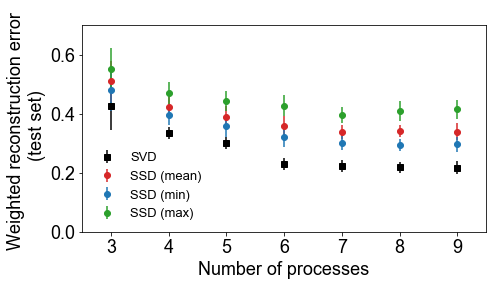

In [23]:
Ks_flat = np.reshape(Ks,(-1,ntrials))
R2_all_ssds_flat  = np.reshape(R2_all_ssds,(-1,ntrials))
R2_all_svds_flat  = np.reshape(R2_all_svds,(-1,ntrials))
modls_flat = np.reshape(modls,(-1,ntrials))
modes_flat = np.reshape(modes,(-1,ntrials))

Krange = np.arange(1,10)
R2_svd_k_nt = np.zeros((len(Krange),ntrials))
R2_ssd_k_nt_mean = np.zeros((len(Krange),ntrials))
R2_ssd_k_nt_max = np.zeros((len(Krange),ntrials))
R2_ssd_k_nt_min = np.zeros((len(Krange),ntrials))

for ik,k in enumerate(Krange):
    for nt in range(ntrials):
        filt_k = Ks_flat[:,nt] == k
        if np.sum(filt_k) > 1e-5:
            R2_svd_k_nt[ik,nt] = np.mean(R2_all_svds_flat[filt_k,nt])
            R2_ssd_k_nt_mean[ik,nt] = np.mean(R2_all_ssds_flat[filt_k,nt])
            R2_ssd_k_nt_max[ik,nt] = np.max(R2_all_ssds_flat[filt_k,nt])
            R2_ssd_k_nt_min[ik,nt] = np.min(R2_all_ssds_flat[filt_k,nt])
        
plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (7,4))
axis.tick_params(labelsize = 18)
axis.set_ylim(0.0,0.7)
axis.set_xlim(2.5,9.5)
axis.errorbar(Krange, 1-np.mean(R2_svd_k_nt,axis=1), yerr = np.std(R2_svd_k_nt,axis=1)/np.sqrt(ntrials), fmt='ks', label = "SVD")
axis.errorbar(Krange, 1-np.mean(R2_ssd_k_nt_mean,axis=1), yerr = np.std(R2_ssd_k_nt_mean,axis=1)/np.sqrt(ntrials), fmt='C3o', label = "SSD (mean)")
axis.errorbar(Krange, 1-np.mean(R2_ssd_k_nt_max,axis=1), yerr = np.std(R2_ssd_k_nt_max,axis=1)/np.sqrt(ntrials), fmt='C0o', label = "SSD (min)")
axis.errorbar(Krange, 1-np.mean(R2_ssd_k_nt_min,axis=1), yerr = np.std(R2_ssd_k_nt_min,axis=1)/np.sqrt(ntrials), fmt='C2o', label = "SSD (max)")


axis.set_ylabel("Weighted reconstruction error \n (test set)", fontsize = 18)
axis.set_xlabel("Number of processes", fontsize = 18)
axis.legend(frameon=False, fontsize = 13, loc  = 3)
fig.tight_layout()
fig.savefig(fig_path + "bicross_svd_ssd_random_80_20_envs.pdf")
plt.show()        

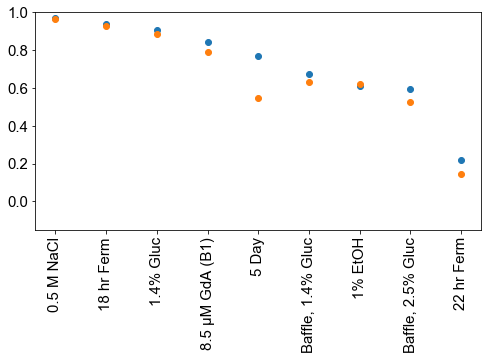

-0.055 6.351 8.000 8


In [24]:
l1 = 0.0001
l2 = 0.01
K = 8
plot_svd_vs_ssd_comparison(F,K,lfilt,efilt,l1,l2, n_types)

## Repeat analysis on Kinsler et al. data with randomly picked 20/188 diploids  

already have directory ./figures/kinsler_red/
('reg', 4, (0.01, 0.1777), (0, 0)) 2.146551724137931 1.78125 3 0.07170738378410055


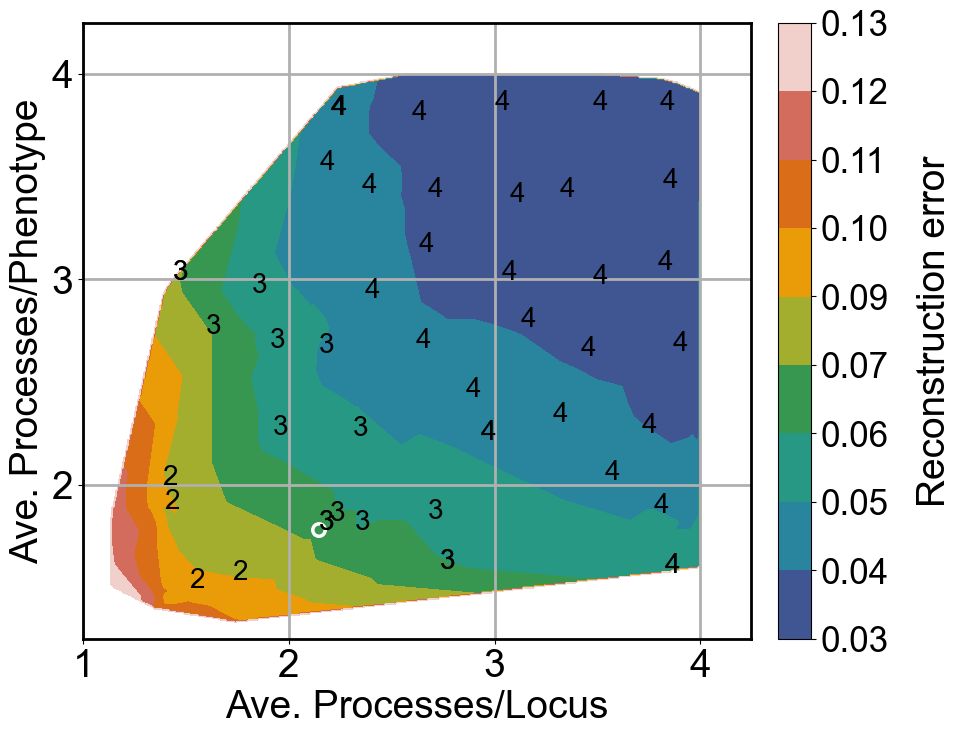

In [20]:
fig_path = "./figures/kinsler_red/"
#create directory if it does not exist
try:
    os.mkdir(fig_path)
except:
    print(f"already have directory {fig_path}")

mode = "kinsler_red"
fcts= pickle.load(open(f"pickled_factorizers/{mode}","rb"))

lamb1_range = 10**(np.linspace(np.log10(1e-4),np.log10(1e-2),25))
lamb2_range = 10**(np.linspace(np.log10(1e-3),np.log10(1.5),25))
lamb1_fixed = [1e-4]
lamb2_fixed = [1e-3]

ve = .25
minx = 1.25-ve
maxx = 4+ve
miny = 1.5-ve
maxy = 4+ve
vmax = 0.13
vmin = 0.03

K = 4

name = mode
fct = fcts[(name , None,None)]

kpts = []
for i in np.linspace(1.5,3.8,7):
    for j in np.linspace(1.5,3.8,7):
        kpts.append((i,j))
        
cps = [(2,1.8)]
kpts += cps

plot_solution_space(fct, K, lamb1_range, lamb2_range,  minx, maxx, miny, maxy, vmax, vmin, \
                    fs = 28,scatter=False, scatter_restricted=True, restrict_in_range = True,\
                    k_labeled_points = kpts, circled_points = cps,  save_name = fig_path + "sols_" + mode + ".pdf")

#plot_solution_space(fct, K, lamb1_range,lamb2_range, minx, maxx, miny, maxy, vmax, vmin,fs = 23,\
                    #scatter=False, scatter_restricted=True, restrict_in_range = True, k_labeled_points = kpts , circled_points = labeled_points, save_name = fig_path + "sols_" + mode + ".pdf")


4 45 120


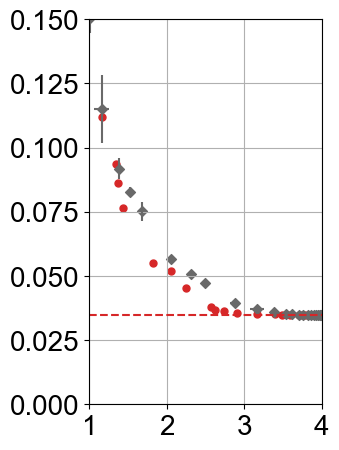

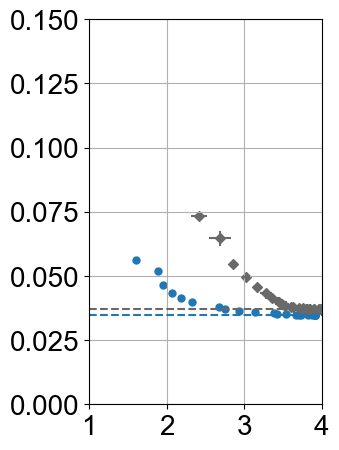

In [21]:
mode = "kinsler_red"
fcts= pickle.load(open(f"pickled_factorizers/{mode}","rb"))

lamb1_range = 10**(np.linspace(np.log10(1e-4),np.log10(1e-2),25))
lamb2_range = 10**(np.linspace(np.log10(1e-3),np.log10(1.5),25))
lamb1_fixed = [1e-4]
lamb2_fixed = [1e-3]
svd_k = 4
mws = 0

yrange = (0,.15)
xrange = (1.5,4)
figsize = (3,5)

name = mode
fct = fcts[(name , None,None)]
K = fct.computed_params(printout = False)[0][1]
print(K, fct.FF.shape[0], fct.FF.shape[1])

fct_rots = [fcts[(name, None, i)] for i in [3,4,5]] 
rotate = "loci"
plot_rotation_test_w_error(fct, fct_rots, K, lamb1_fixed, lamb2_range, xrange, yrange, rotate, fs = 20, svd_k=K, true_line = False, save_name = f"{fig_path}/{rotate}_rot_test.pdf", figsize = figsize, xticks = [1,2,3,4], oc='tab:red', rotc='dimgrey', labels= None, legend = False)

fct_rots = [fcts[(name, i, None)] for i in [0,1,2]] 
rotate = "env"
plot_rotation_test_w_error(fct, fct_rots, K, lamb1_range, lamb2_fixed, xrange, yrange, rotate, fs = 20, svd_k=K, true_line = False, save_name = f"{fig_path}/{rotate}_rot_test.pdf", figsize = figsize, xticks = [1,2,3,4], oc='tab:blue', rotc='dimgrey', labels= None, legend = False)



M: plot



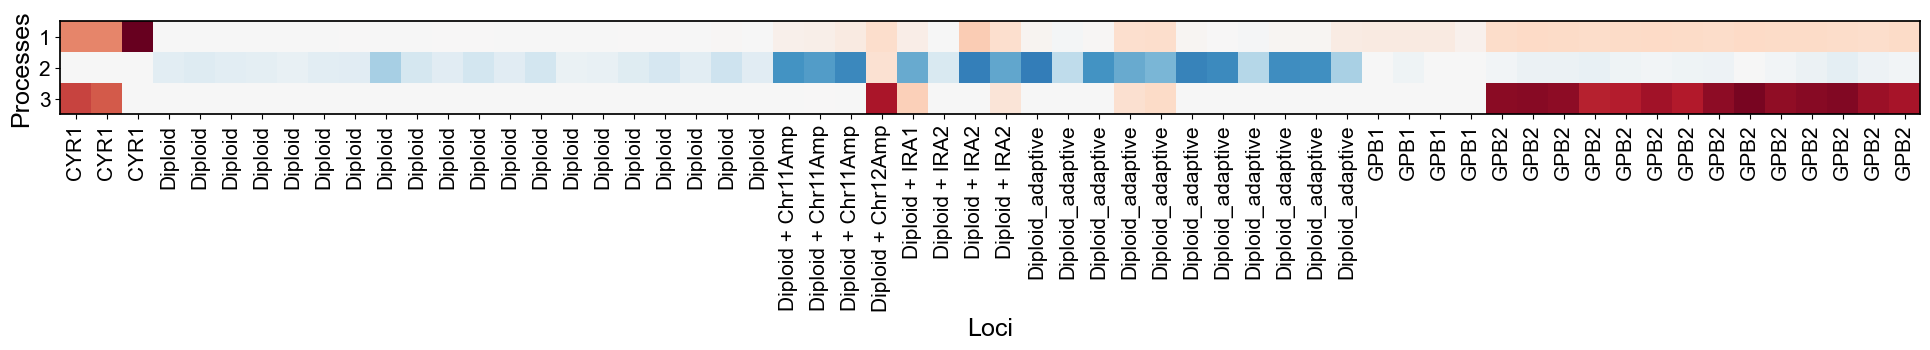

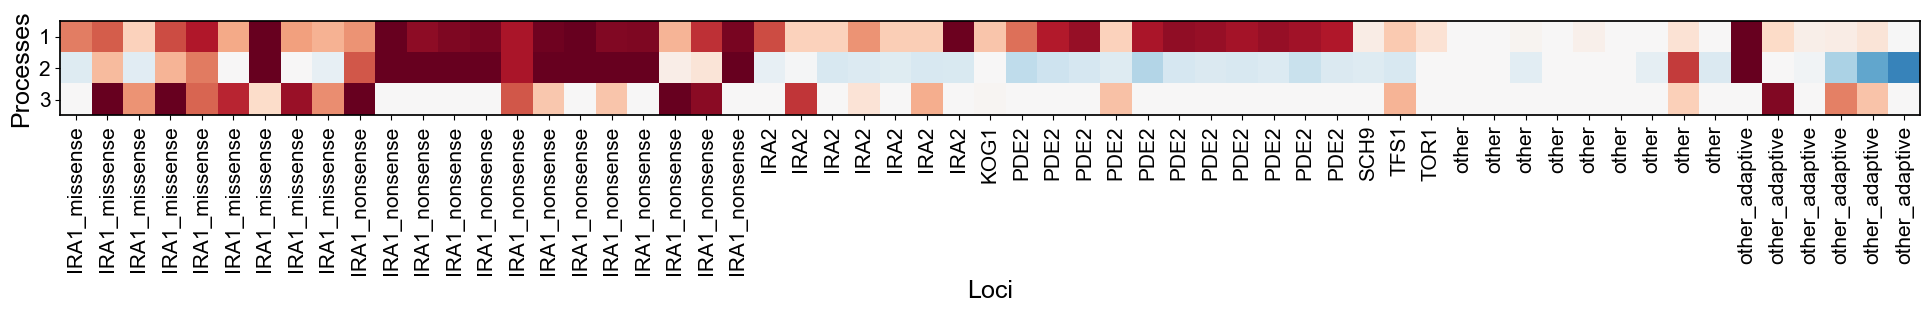

In [22]:
p = fct.find_key(2,1.8)
M = fct.M_preds[p]

filt = np.sum(M**2,axis=0) > 1e-4

Z = linkage(M.T[filt], metric = cosine_abs, method = 'complete', optimal_ordering=True)

cluster_labels = np.zeros(M.shape[1])
cluster_labels[filt] = hac.fcluster(Z,0.2, criterion='distance')

plot_Ms(fct,p,save_name = fig_path + "M_" + mode + ".pdf")

In [23]:
p = fct.find_key(2,1.8)
M = fct.M_preds[p]
F = fct.FTrue

filt = np.sum(M**2,axis=0) > 1e-4

Z = linkage(M.T[filt], metric = cosine_abs, method = 'complete', optimal_ordering=True)

cluster_labels = np.zeros(M.shape[1])
cluster_labels[filt] = hac.fcluster(Z,0.22, criterion='distance')

mapp = np.arange(int(np.max(cluster_labels))+1)
cluster_labels_new = deepcopy(cluster_labels)
for ic,c in enumerate(cluster_labels):
    cluster_labels_new[ic] = mapp[int(cluster_labels[ic])]
    
cluster_labels = deepcopy(cluster_labels_new)

print(np.max(cluster_labels))

7.0


In [24]:
loci_types = fct.loci_names
types_filt = deepcopy(loci_types)

loci_types_unique = []
for i in range(1,len(loci_types)):
    if loci_types[i-1] != loci_types[i]:
        loci_types_unique += [loci_types[i-1]]
loci_types_unique += [loci_types[-1]]

F_by_type = np.zeros((F.shape[0], len(loci_types_unique)))
num_by_type = np.zeros(len(loci_types_unique))
for it,t in enumerate(loci_types_unique):
    indices_by_type = [i for i,lt in enumerate(loci_types) if lt == t]
    #print(t, indices_by_type)
    F_by_type[:,it] = np.mean(F[:,indices_by_type],axis=1)# - 0*np.mean(F_EC_avg[indices_by_type])
    num_by_type[it] = len(indices_by_type)
    
    #print(F_by_type[:,it])

sort_by_pathway = [1,2,3,4,5,6,0,7,8,9,10,11,13,15,16,14,12,17,18]
loci_types_by_pathway = [loci_types_unique[i] for i in sort_by_pathway]

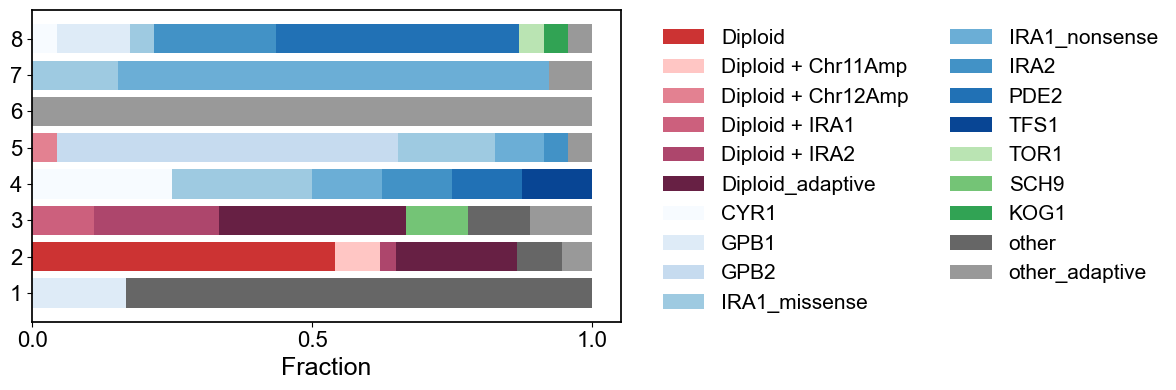

In [25]:
from palettable.colorbrewer.sequential import Blues_8
from palettable.colorbrewer.sequential import Greens_5
from palettable.cartocolors.qualitative import Antique_10
from palettable.cartocolors.sequential import Burg_5
from palettable.cartocolors.sequential import BluYl_6
from palettable.cartocolors.sequential import Emrld_6


cmap_colors = [(0.8,0.2,0.2)] + Burg_5.mpl_colors + Blues_8.mpl_colors + Greens_5.mpl_colors[1:4] + \
[(0.4,0.4,0.4)] + [(0.6,0.6,0.6)]

ncolors = len(cmap_colors)

num_clusters = int(np.max(cluster_labels))+1
type_distribution_by_cluster = np.zeros((num_clusters,len(loci_types_by_pathway)))
count = 0
for i in range(num_clusters):
    filt = cluster_labels == i 
    lnames = [l for j,l in enumerate(np.sort(types_filt)) if filt[j]]
    count += sum(filt)
    #print(sum(filt), lnames, count)
    for iu,u in enumerate(loci_types_by_pathway):
        counter = [1 for l in lnames if l == u]
        type_distribution_by_cluster[i,iu] = np.sum(counter)

#print(type_distribution_by_cluster)

type_frac_by_cluster = type_distribution_by_cluster/np.sum(type_distribution_by_cluster,axis=1)[:,None]

plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (12,4))



for iu,u in enumerate(loci_types_by_pathway):
    if iu == 0:
        axis.barh(np.arange(num_clusters)+1,type_frac_by_cluster[:,0], color = cmap_colors[iu%ncolors], label = u)
    else:
        axis.barh(np.arange(num_clusters)+1,type_frac_by_cluster[:,iu], \
                 left = np.sum(type_frac_by_cluster[:,:iu],axis=1), color = cmap_colors[iu%ncolors], label = u)

        #
            
axis.set_xlim(0,1.05)
#axis.set_ylim(0,1.05)
axis.tick_params(labelsize = 16)
axis.legend(fontsize = 15, bbox_to_anchor=(1.04,1), loc="upper left", frameon= False, ncol =2)
#axis.set_ylabel("Groups", fontsize = 22)
axis.set_xlabel("Fraction", fontsize = 18)
axis.set_yticks(np.arange(type_frac_by_cluster.shape[0])+1)
axis.set_xticks([0,0.5,1])
#yticklabels = ["Other", "Diploids","Ras/TOR","Ras","Chr11/adaptive","Diploid+adaptive","IRA1+other","IRA1"]
num_per_group = np.sum(type_distribution_by_cluster,axis=1,dtype=int)
#yticklabels = [x + " (%d)"%num_per_group[i] for i,x in enumerate(yticklabels)]
#axis.set_yticklabels(yticklabels)


for sp in ['top','bottom','left','right']:
    axis.spines[sp].set_linewidth(1.25)


fig.tight_layout()
fig.savefig(fig_path + mode + "_loci_clusters.pdf")
plt.show()

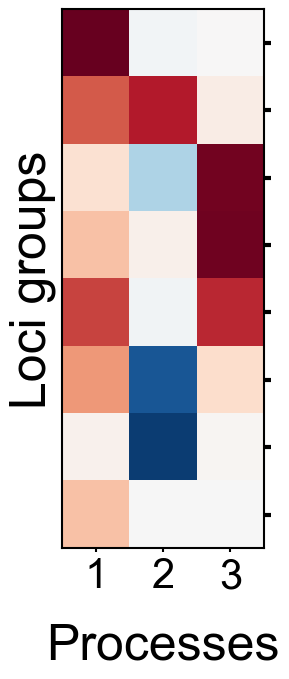

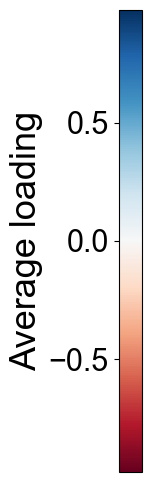

In [26]:
l_names = fct.loci_names 
params = fct.find_key(1.8,2)
M = fct.M_preds[params]

save_name = fig_path + "M_" + mode + ".pdf"

# if restricted is not None and sort == "names":
#     M = M[:,restricted]
#     l_names = [l for i,l in enumerate(l_names) if restricted[i]]

M, _ = cut_zero_mods(fct.M_preds[params],fct.W_preds[params])

Mnorm = M/np.sqrt(np.sum(M**2 + 1e-5,axis=0))

Mnew = np.zeros((M.shape[0],int(np.max(cluster_labels)+1)))
for i in range(Mnew.shape[1]):
    Mnew[:,i] = np.mean(Mnorm[:,cluster_labels == i],axis=1)

sorted_ = np.ones(Mnew.shape[1],dtype = bool)
M = deepcopy(Mnew)
l_names = np.arange(Mnew.shape[1]) + 1

xlabel = "Groups"

numl = M.shape[1]
pp = 99
labelsize = 30
colorlabels = ["k" for i in range(M.shape[1])]

plt.close("all")
fig, axis = plt.subplots(1, 1, figsize=(24, 7))
mm = np.percentile(np.abs(M), pp)
# print(mm, np.max(np.abs(M)))
im = axis.imshow(M[:, ::-1].T, cmap="RdBu", vmin=-mm, vmax=mm)
axis.tick_params(labelsize=labelsize, length= 3, width = 1.5)
axis.set_yticks(np.arange(numl))
axis.set_yticklabels([])
axis.yaxis.tick_right()

axis.set_xticks(np.arange(M.shape[0]))
axis.set_xticklabels(np.arange(M.shape[0])+1)
axis.yaxis.set_tick_params(length = 5, width = 3)
axis.set_ylabel("Loci groups",fontsize = labelsize*1.2)
#axis.set_xticklabels(np.arange(M.shape[0]))
[t.set_color(colorlabels[i]) for i, t in enumerate(axis.xaxis.get_ticklabels())]
axis.set_xlabel("Processes",fontsize = labelsize*1.2, labelpad = 20)

for sp in ["top", "bottom", "left", "right"]:
    axis.spines[sp].set_linewidth(1.5)
    
fig.savefig(save_name, bbox_inches='tight')
plt.show()

plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (8,6))
ax = fig.add_subplot(111)
cb = fig.colorbar(mappable=im,ax=[ax],location='left')
cb.ax.tick_params(labelsize = 22)
cb.set_label("Average loading", fontsize = 26)
ax.remove()
axis.remove()
fig.savefig(fig_path + "M_" + mode + "cb.pdf")

plt.show()





W: plot



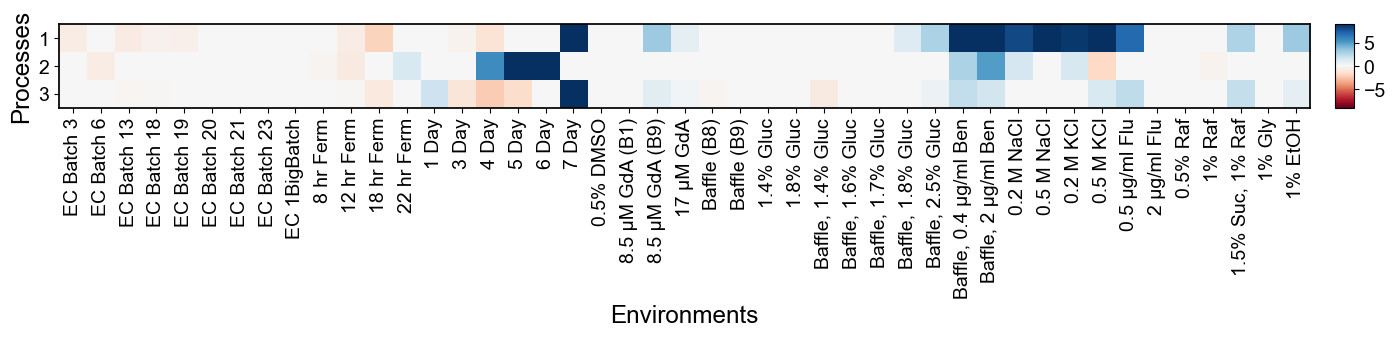

71
Module 	 Number of loci included
0	 98
1	 105
2	 46


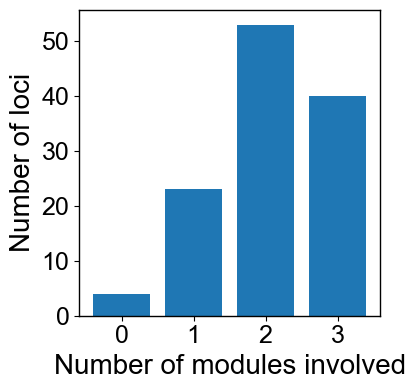

In [27]:
p = fct.find_key(2,1.8)
aspect = [1.02,0.0,0.015,1]
ordering = [1,2,3,4,0,5,6,7,28,9,8,11,10,12,13,14,15,16,17]
ordering += [18,19,36,37,21,29,30,31,20,22,23,24,25,26,27,32,33,34,35,39,38,41,40,44,42,43]
plot_Ws(fct, p, pp = 95, labelsize = 14,save_name = fig_path + "W_" + mode + ".pdf", \
        colorbar_aspect = aspect,ordering = ordering)
F = fct.FF
filtl =  np.mean(np.abs(F),axis=0) > 0.9
print(np.sum(filtl))
#plot_Ms(fct, p, pp = 97, restricted = filtl, two_line= False, labelsize = 24, max_cols = 120, save_name = fig_path + "M_" + mode + ".pdf")
display_modularity(fct, p, save_name =  fig_path + "modhist_" + mode + ".pdf")  